In [1]:
import os
import shutil

from google.colab import drive
drive.mount('/content/drive')

def copy_files_recursive(source_folder, destination_folder):
    for root, dirs, files in os.walk(source_folder):
        for file in files:
            source_path = os.path.join(root, file)
            destination_path = os.path.join(destination_folder, os.path.relpath(source_path, source_folder))

            # Create destination directories if they don't exist
            os.makedirs(os.path.dirname(destination_path), exist_ok=True)

            shutil.copyfile(source_path, destination_path)

source_folder = '/content/drive/My Drive/Project/cropped_images_new/content/drive/MyDrive/Project'
destination_folder = '/content/cropped_images_new'
copy_files_recursive(source_folder, destination_folder)

Mounted at /content/drive


#Data Preparation

In [2]:
from google.colab import drive
import pandas as pd
import json
import torch
import torchvision

#drive.mount("/content/drive")

In [3]:
import copy
import json
import os
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import DataLoader

# set a constant instead of random seed for repeatability
torch.manual_seed(42)

%matplotlib inline

In [ ]:
mapped_crops_df = pd.read_csv('/content/drive/MyDrive/Project/mapped_crops_table.csv')

In [4]:
import pandas as pd
import re

#sorting entries alphabetically by their crop path so that entries in the same or similar folders are near to eachother
#making image loading from google drive more efficient

def sort_by_letters(df, column_name):
  """
  Sorts a DataFrame by the letters in a specified column, ignoring special characters and considering case.

  Args:
      df (pandas.DataFrame): The DataFrame to sort.
      column_name (str, optional): The name of the column to sort by. Defaults to 'SourceFile'.

  Returns:
      pandas.DataFrame: The sorted DataFrame.
  """

  def remove_special_chars(text):
    return re.sub(r"[^\w\s]", "", text)  # Remove non-alphanumeric characters

  df['SortKey'] = df[column_name].apply(remove_special_chars).str.lower()
  sorted_df = df.sort_values(by='SortKey').drop('SortKey', axis=1)
  return sorted_df

In [ ]:
sorted_mapped_crops_df = sort_by_letters(mapped_crops_df, 'crop_path')

In [ ]:
sorted_mapped_crops_df.iloc[1,5]

'/content/drive/MyDrive/Project/cropped_images_new//content/drive/MyDrive/Project/Hampstead Heath 2021/124to136/124_1_HH_2021_14_6_21_9days/100_BTCF/IMG_0072.JPG___crop05_md_v5a.0.0.pt.jpg'

In [ ]:
sorted_mapped_crops_df.iloc[:,5] = sorted_mapped_crops_df.iloc[:,5].str.replace('/drive/MyDrive/Project', '')

In [ ]:
sorted_mapped_crops_df.iloc[:,5] = sorted_mapped_crops_df.iloc[:,5].str.replace('//', '/')

In [ ]:
sorted_mapped_crops_df.iloc[:,5] = sorted_mapped_crops_df.iloc[:,5].str.replace('new/content', 'new')

In [ ]:
sorted_mapped_crops_df.iloc[1,5]

'/content/cropped_images_new/Hampstead Heath 2021/124to136/124_1_HH_2021_14_6_21_9days/100_BTCF/IMG_0072.JPG___crop05_md_v5a.0.0.pt.jpg'

#Train, Validation, Test Splits

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define test size
test_size = 0.2

# Stratified split by PlaceID for balanced representation
train_val_df, test_df = train_test_split(sorted_mapped_crops_df, test_size=test_size, random_state=42)

# Further split train/val (adjust validation size as needed)
val_size = 0.2  # 20% of train_val for validation
train_df, val_df = train_test_split(train_val_df, test_size=val_size, random_state=42)

# Add split column
train_df['split'] = 'train'
val_df['split'] = 'val'
test_df['split'] = 'test'

# Combine DataFrames (optional, use individual DataFrames for training)
all_data_df = pd.concat([train_df, val_df, test_df])


In [ ]:
sorted_all_data_df = sort_by_letters(all_data_df, 'crop_path')

In [ ]:
sorted_all_data_df.iloc[50000,5]

'/content/cropped_images_new/Hampstead Heath 2021/HH21_30/30_1_HH_2021_10_6_21_/100_BTCF/IMG_1677.JPG___crop01_md_v5a.0.0.pt.jpg'

In [ ]:
# 1. Assign targetIDs based on unique species
species_mapping = {species: i for i, species in enumerate(sorted_all_data_df['Subject'].unique())}
sorted_all_data_df['targetID'] = sorted_all_data_df['Subject'].apply(lambda x: species_mapping[x])

# 2. Create a dictionary to store split data
data_dict = {
    'train': [],
    'val': [],
    'test': []
}

# 3. Populate data based on split
for index, row in sorted_all_data_df.iterrows():
  data = [
      row['crop_path'],
      row['targetID'],
      row['Subject'],
      row['PlaceID']  # Assuming a column named 'PlaceID'
  ]
  data_dict[row['split']].append(data)


#Species image figures

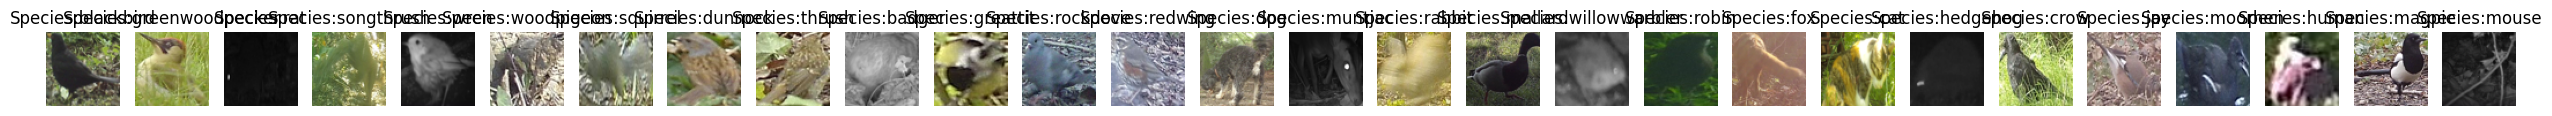

In [ ]:
fig = plt.figure(figsize=(25, 12))

for i, sp in enumerate(set(sorted_all_data_df.Subject), 1):
    sample_row = sorted_all_data_df.query("Subject==@sp").sample(1).iloc[0]
    fig.add_subplot(1, 28, i)
    img_path = sample_row.crop_path
    img = np.array(Image.open(img_path).resize((64, 64)))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Species:{}".format(sample_row.Subject))
plt.tight_layout()
plt.show()

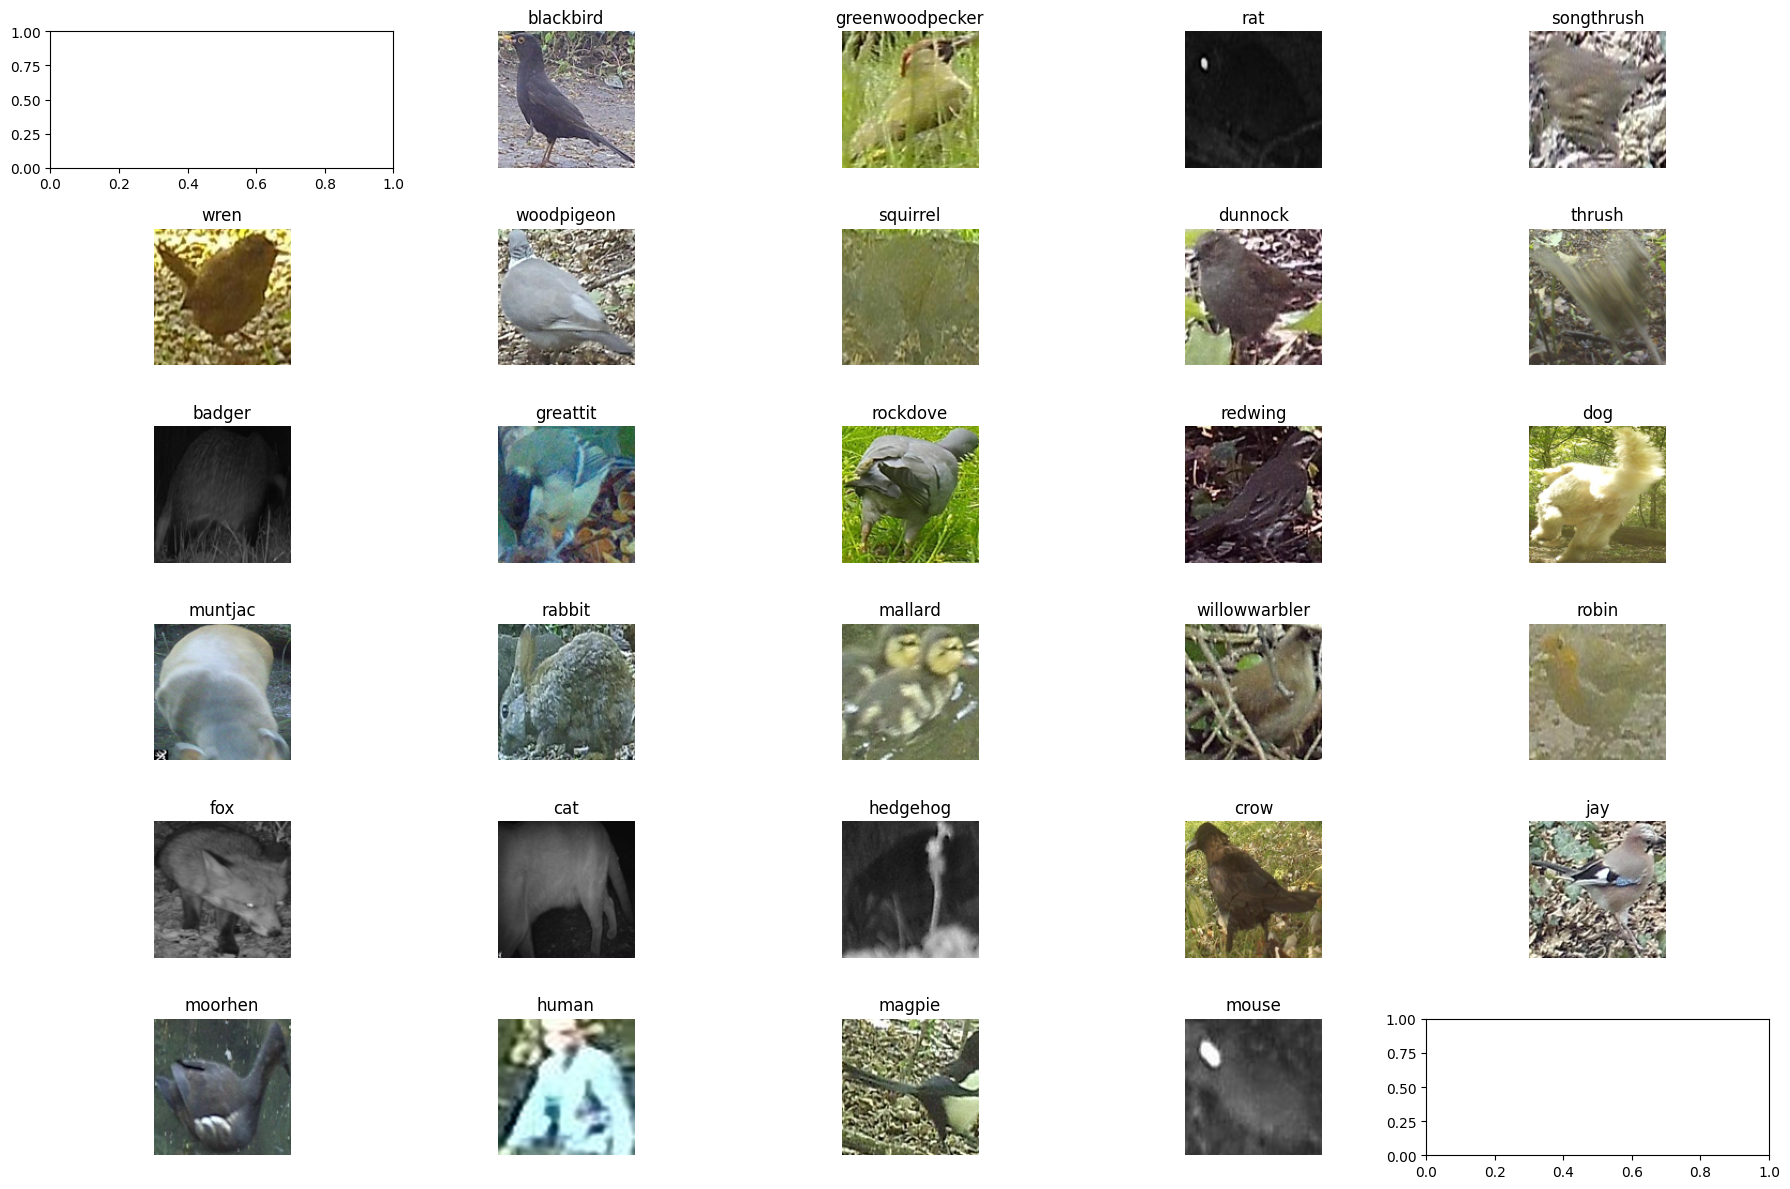

In [ ]:
import matplotlib.pyplot as plt
from math import ceil, sqrt  # for calculating number of rows and columns

# Assuming sorted_all_data_df is your DataFrame

num_images = len(set(sorted_all_data_df.Subject))  # Number of unique species
rows = int(ceil(sqrt(num_images)))  # Calculate number of rows for rectangle formation
cols = int(ceil(num_images / rows))  # Calculate number of columns

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))  # Create a figure with subplots

# Flatten the axes for easier iteration
axes_flat = axes.ravel()

for i, sp in enumerate(set(sorted_all_data_df.Subject), 1):
    sample_row = sorted_all_data_df.query("Subject==@sp").sample(1).iloc[0]
    img_path = sample_row.crop_path
    img = np.array(Image.open(img_path).resize((128, 128)))  # Increase image size

    # Access the current axis using indexing based on flattened list
    ax = axes_flat[i]
    ax.imshow(img)
    ax.axis("off")  # Hide axis labels
    ax.set_title(sample_row.Subject)

# Adjust layout to prevent overlapping elements
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/Project/species_grid4.png')

plt.show()


#1st Model Training (resnet18) FFE

In [5]:
import numpy as np
import glob
import cv2
from torch.utils.data import Dataset, DataLoader

In [6]:
#new transforms

img_res = 224

train_transform = T.Compose([
    T.Resize(size=img_res, interpolation=Image.BICUBIC),
    T.CenterCrop(img_res),  # Add CenterCrop to ensure all images have the same dimensions
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = T.Compose([
    T.Resize(size=img_res, interpolation=Image.BICUBIC),
    T.CenterCrop(img_res),  # Add CenterCrop to ensure all images have the same dimensions
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [7]:
import os
import pandas as pd
from torchvision.io import read_image

class SpeciesDataset(Dataset):
  def __init__(self, data_dict, split, transform=None):
    self.data = data_dict[split]  # Access data for specific split
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image_path, target_id, subject, place_id = self.data[idx]
    # Load image
    #print(f'loading image path {idx}')
    image = cv2.imread(image_path)  # Assuming OpenCV for loading
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (if necessary)
    image = Image.fromarray(image)
    #print(f'image path loaded')
    if self.transform is not None:
      image = self.transform(image)
    return image, target_id


In [ ]:
train_data = SpeciesDataset(data_dict, 'train', transform=train_transform)
val_data = SpeciesDataset(data_dict, 'val', transform=val_test_transform)
test_data = SpeciesDataset(data_dict, 'test', transform=val_test_transform)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=300, shuffle=False, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=300, shuffle=False, pin_memory=True, num_workers=8)
val_dataloader = DataLoader(val_data, batch_size=300, shuffle=False, pin_memory=True, num_workers=8)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [78]:
num_classes = 28

In [79]:
device = "cuda"

model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_classes)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [9]:
def train_phase(model, criterion, optimizer, scheduler):
  """
  This function performs the training phase for a single epoch.

  Args:
      model: The PyTorch model to train.
      criterion: The loss function used for calculating training loss.
      optimizer: The optimizer used for updating model weights.
      scheduler: The learning rate scheduler (optional).
  """

  model.train()  # Set the model to training mode (affects layers like dropout)

  running_loss = 0.0
  running_corrects = 0

  # Iterate over data batches from the training loader
  for inputs, labels in train_dataloader:
    #print(f'-------------------New Batch---------------------')
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Clear gradients from previous iteration
    optimizer.zero_grad()

    # Forward pass
    with torch.set_grad_enabled(True):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)  # Get the predicted class labels
      loss = criterion(outputs, labels)  # Calculate the loss

      # Backward pass and optimize
      loss.backward()
      optimizer.step()

    # Statistics
    running_loss += loss.item() * inputs.size(0)  # Update running loss
    running_corrects += torch.sum(preds == labels.data).item()

  epoch_loss = running_loss / len(train_dataloader.dataset)
  epoch_acc = running_corrects / len(train_dataloader.dataset)

  # Print training statistics for the epoch
  print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

  # Optional: Step learning rate scheduler after each epoch
  if scheduler is not None:
    scheduler.step()

  return epoch_acc #return training accuracy


def val_phase(model, criterion):
  """
  This function performs the validation phase for a single epoch.

  Args:
      model: The PyTorch model to validate.
      criterion: The loss function used for calculating validation loss.
  """

  model.eval()   # Set the model to evaluation mode (affects layers like dropout)

  running_loss = 0.0
  running_corrects = 0

  # Iterate over data batches from the validation loader
  with torch.no_grad():
    for inputs, labels in val_dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

      # Statistics
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data).item()

  epoch_loss = running_loss / len(val_dataloader.dataset)
  epoch_acc = running_corrects / len(val_dataloader.dataset)

  # Print validation statistics for the epoch
  print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

  return epoch_acc  # Return validation accuracy for best model tracking

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  train_acc_list = []
  val_acc_list = []

  for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has training and validation phases
    train_acc = train_phase(model, criterion, optimizer, scheduler)
    val_acc = val_phase(model, criterion)

    #print(train_acc)
    #print(val_acc)

    # store training and validation accuracies through training stage. these should be getting better as we train
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    #print(f'{val_acc_list = }')
    #print(f'{train_acc_list = }')

    # Deep copy the model if validation accuracy is the best so far
    if val_acc > best_acc:
      best_acc = val_acc
      best_model_wts = copy.deepcopy(model.state_dict())

    scheduler.step()  # Step learning rate scheduler

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # Load best model weights
  model.load_state_dict(best_model_wts)
  return {'model': model, 'train_acc_list': train_acc_list, 'val_acc_list': val_acc_list}

In [ ]:
trained_model = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

In [ ]:
torch.save(trained_model.state_dict(), '/content/drive/MyDrive/Project/species_classifier3.pt')

species_classifier2.pt is the weights created by 5 epochs with the original transforms applied below

best validation accuracy was 68%

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

species_classifier3.pt is the weights created by 25 epochs

new transforms

best validation accuracy was 76%

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
 img_res = 224

# image transformation to augment our dataset for better training.
# the outcome of these transformation will be the input of the deep learning model
train_transform = T.Compose(
    [
        T.Resize(size=img_res),
        T.RandomCrop(size=img_res),
        T.RandomHorizontalFlip(),
        T.RandomApply(
            [T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)]
        ),
        T.RandomGrayscale(),
        T.ToTensor(),
    ]
)

val_test_transform = T.Compose(
    [
        T.Resize(size=img_res),
        T.CenterCrop(size=img_res),
        T.ToTensor(),
    ]
)

#Testing performance of model 1 on unseen test set

In [80]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier3.pt')

model_conv.load_state_dict(best_model_wts)

# Set the model to evaluation mode
model_conv.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [81]:
# Set your model to evaluation mode
model_conv.eval()

# Define a function for evaluation
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_targets

# Evaluate on the test set
test_predictions, test_targets = evaluate_model(model_conv, test_dataloader)

# Now you can use test_predictions and test_targets to calculate evaluation metrics
# For example:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.022097915029356017


In [ ]:
df_results = pd.DataFrame({'Test_Predictions': test_predictions, 'Test_Targets': test_targets})

df_results.head()

,Test_Predictions,Test_Targets
0,1,0
1,1,1
2,1,1
3,1,1
4,1,1


In [ ]:
match_count = 0

for index, row in df_results.iterrows():
  if row['Test_Predictions'] == row['Test_Targets']:
    match_count += 1

percentage_match = (match_count/len(df_results)) * 100

percentage_match

76.58816237991944

In [ ]:
# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['Test_Predictions'] = df_results['Test_Predictions'].map(id_to_species_mapping)
df_results['Test_Targets'] = df_results['Test_Targets'].map(id_to_species_mapping)


In [ ]:
df_results.head()

,Test_Predictions,Test_Targets
0,dog,human
1,dog,dog
2,dog,dog
3,dog,dog
4,dog,dog


In [ ]:
df_results.to_csv('/content/drive/MyDrive/Project/testdata_predictions_table_classifier3.csv', index=False)

In [ ]:
match_count = 0

for index, row in df_results.iterrows():
  if row['Test_Predictions'] == row['Test_Targets']:
    match_count += 1

percentage_match = (match_count/len(df_results)) * 100

percentage_match

76.58816237991944

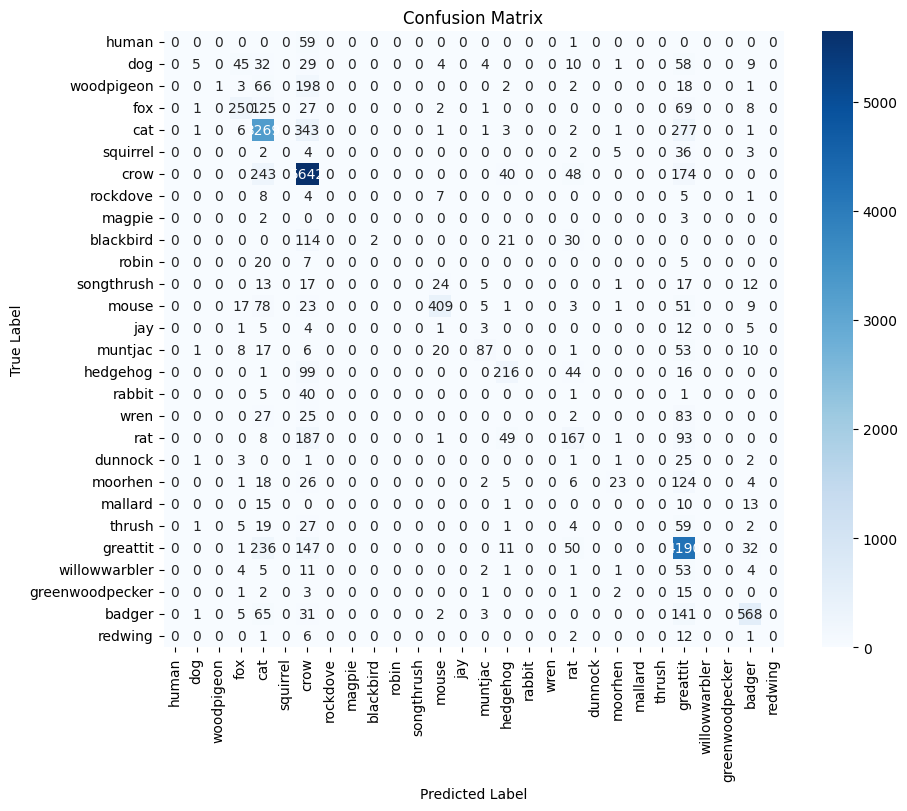

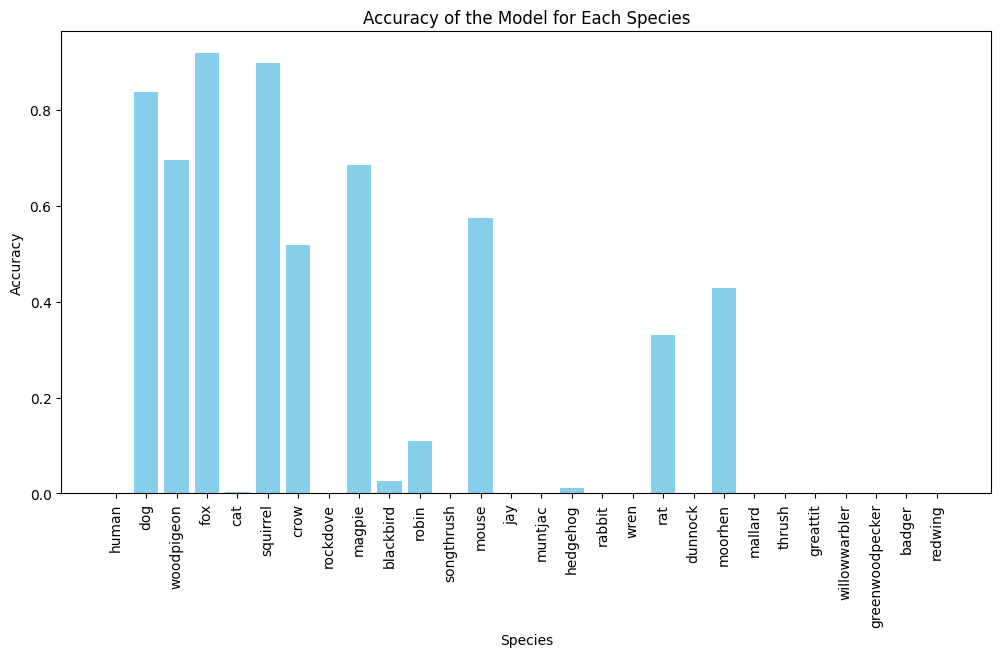

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(df_results['Test_Targets'], df_results['Test_Predictions'])

# Calculate overall accuracy
overall_accuracy = accuracy_score(df_results['Test_Targets'], df_results['Test_Predictions'])

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=id_to_species_mapping.values(), yticklabels=id_to_species_mapping.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy for each species
species_accuracy = {}
for species in id_to_species_mapping.values():
    species_df = df_results[df_results['Test_Targets'] == species]
    accuracy = accuracy_score(species_df['Test_Targets'], species_df['Test_Predictions'])
    species_accuracy[species] = accuracy

# Plot bar chart showing accuracy for each species
plt.figure(figsize=(12, 6))
plt.bar(species_accuracy.keys(), species_accuracy.values(), color='skyblue')
plt.xlabel('Species')
plt.ylabel('Accuracy')
plt.title('Accuracy of the Model for Each Species')
plt.xticks(rotation=90)
plt.show()


#Second Model Architecture Training (resnet50) FFE

In [ ]:
device = "cuda"

model_conv = torchvision.models.resnet50(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_classes)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every n epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.1)

In [ ]:
result = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
Train Loss: 10.4059 Acc: 0.5287
Val Loss: 25.1748 Acc: 0.2377
Epoch 2/25
----------
Train Loss: 12.4312 Acc: 0.5543
Val Loss: 24.2579 Acc: 0.2933
Epoch 3/25
----------
Train Loss: 13.2164 Acc: 0.5555
Val Loss: 20.9320 Acc: 0.2811
Epoch 4/25
----------
Train Loss: 13.7774 Acc: 0.5588
Val Loss: 17.6294 Acc: 0.3129
Epoch 5/25
----------
Train Loss: 13.7553 Acc: 0.5649
Val Loss: 15.1235 Acc: 0.3570
Epoch 6/25
----------
Train Loss: 13.5208 Acc: 0.5696
Val Loss: 14.3000 Acc: 0.3590
Epoch 7/25
----------
Train Loss: 13.4387 Acc: 0.5741
Val Loss: 13.5842 Acc: 0.3770
Epoch 8/25
----------
Train Loss: 13.4628 Acc: 0.5762
Val Loss: 13.9058 Acc: 0.3769
Epoch 9/25
----------
Train Loss: 13.4743 Acc: 0.5771
Val Loss: 13.4417 Acc: 0.3900
Epoch 10/25
----------
Train Loss: 13.2472 Acc: 0.5827
Val Loss: 13.4888 Acc: 0.3898
Epoch 11/25
----------
Train Loss: 13.3199 Acc: 0.5818
Val Loss: 12.0782 Acc: 0.4165
Epoch 12/25
----------
Train Loss: 13.2298 Acc: 0.5845
Val Loss: 13.2138 A

KeyboardInterrupt: 

In [ ]:
trained_model = result['model']
train_acc_list_c4 = result['train_acc_list']
val_acc_list_c4 = result['val_acc_list']

NameError: name 'result' is not defined

In [ ]:
torch.save(trained_model.state_dict(), '/content/drive/MyDrive/Project/species_classifier5.pt')

In [ ]:
import csv

with open('/content/drive/MyDrive/Project/Accuracy CSVs/train_acc_list_c5.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(train_acc_list_c4)

with open('/content/drive/MyDrive/Project/Accuracy CSVs/val_acc_list_c5.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(val_acc_list_c4)


Classifier 4 is resnet50

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=20, gamma=0.1)

25 epochs

Classifier 5 is resnet50

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.1)

25 epochs

**Didn't finish training as accuracies were very low**

#Testing accuracy of model 2 on test set

In [ ]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier4.pt')

model_conv.load_state_dict(best_model_wts)

# Set the model to evaluation mode
model_conv.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Set your model to evaluation mode
model_conv.eval()

# Define a function for evaluation
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_targets

# Evaluate on the test set
test_predictions, test_targets = evaluate_model(model_conv, test_dataloader)

# Now you can use test_predictions and test_targets to calculate evaluation metrics
# For example:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

Test accuracy: 0.7805495300072307


In [ ]:
df_results = pd.DataFrame({'Test_Predictions': test_predictions, 'Test_Targets': test_targets})

df_results.head()

,Test_Predictions,Test_Targets
0,8,0
1,1,1
2,1,1
3,1,1
4,1,1


In [ ]:
# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['Test_Predictions'] = df_results['Test_Predictions'].map(id_to_species_mapping)
df_results['Test_Targets'] = df_results['Test_Targets'].map(id_to_species_mapping)

In [ ]:
df_results.head()

,Test_Predictions,Test_Targets
0,magpie,human
1,dog,dog
2,dog,dog
3,dog,dog
4,dog,dog


In [ ]:
df_results.to_csv('/content/drive/MyDrive/Project/testdata_predictions_table_classifier4.csv', index=False)

#Training 3rd Model Architecture (Convnext) FFE

In [ ]:
model_conv = models.convnext_base(weights='IMAGENET1K_V1')
device = "cuda"
for param in model_conv.parameters(): param.requires_grad = False
model_conv.classifier[2] = torch.nn.Linear(
    in_features=model_conv.classifier[2].in_features,
    out_features=28
)
model_conv = model_conv.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.classifier[2].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=20, gamma=0.1)

In [ ]:
result = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

In [ ]:
trained_model_c6 = result['model']
train_acc_list_c6 = result['train_acc_list']
val_acc_list_c6 = result['val_acc_list']

In [ ]:
torch.save(trained_model_c6.state_dict(), '/content/drive/MyDrive/Project/species_classifier6.pt')

In [ ]:
import csv

with open('/content/drive/MyDrive/Project/Accuracy CSVs/train_acc_list_c6.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(train_acc_list_c6)

with open('/content/drive/MyDrive/Project/Accuracy CSVs/val_acc_list_c6.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(val_acc_list_c6)

Classifier 6 is ConvNext_base

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.classifier[2].parameters(), lr=0.001 momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=20, gamma=0.1)

25 epochs

#Testing Accuracy of 3rd Architecture on Test Set

In [ ]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier6.pt')

model_conv.load_state_dict(best_model_wts)

# Set the model to evaluation mode
model_conv.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [ ]:
# Set your model to evaluation mode
model_conv.eval()

# Define a function for evaluation
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_targets

# Evaluate on the test set
test_predictions, test_targets = evaluate_model(model_conv, test_dataloader)

# Now you can use test_predictions and test_targets to calculate evaluation metrics
# For example:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

Test accuracy: 0.8807457907240988


In [ ]:
df_results = pd.DataFrame({'Test_Predictions': test_predictions, 'Test_Targets': test_targets})

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['Test_Predictions'] = df_results['Test_Predictions'].map(id_to_species_mapping)
df_results['Test_Targets'] = df_results['Test_Targets'].map(id_to_species_mapping)

df_results.head()

,Test_Predictions,Test_Targets
0,human,human
1,dog,dog
2,dog,dog
3,dog,dog
4,dog,dog


In [ ]:
df_results.to_csv('/content/drive/MyDrive/Project/testdata_predictions_table_classifier6.csv', index=False)

#Training 4th Model Architecture (Convnext) FineTuning

In [ ]:
device = "cuda"

model_ft = models.convnext_base(weights='IMAGENET1K_V1')
model_ft.classifier[2] = torch.nn.Linear(
    in_features=model_ft.classifier[2].in_features,
    out_features=28
)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

In [ ]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier7.pt')

model_ft.load_state_dict(best_model_wts)

<All keys matched successfully>

In [ ]:
result = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------
Train Loss: 0.2437 Acc: 0.9318
Val Loss: 0.3037 Acc: 0.9136
Epoch 2/10
----------
Train Loss: 0.2470 Acc: 0.9318
Val Loss: 0.3027 Acc: 0.9140
Epoch 3/10
----------
Train Loss: 0.2460 Acc: 0.9316
Val Loss: 0.3010 Acc: 0.9145
Epoch 4/10
----------
Train Loss: 0.2426 Acc: 0.9327
Val Loss: 0.3002 Acc: 0.9146
Epoch 5/10
----------
Train Loss: 0.2417 Acc: 0.9332
Val Loss: 0.3026 Acc: 0.9143
Epoch 6/10
----------
Train Loss: 0.2388 Acc: 0.9343
Val Loss: 0.3004 Acc: 0.9140
Epoch 7/10
----------
Train Loss: 0.2362 Acc: 0.9350
Val Loss: 0.2969 Acc: 0.9150
Epoch 8/10
----------
Train Loss: 0.2327 Acc: 0.9357
Val Loss: 0.2986 Acc: 0.9150
Epoch 9/10
----------
Train Loss: 0.2556 Acc: 0.9286
Val Loss: 0.2470 Acc: 0.9323
Epoch 10/10
----------
Train Loss: 0.2395 Acc: 0.9321
Val Loss: 0.2427 Acc: 0.9331
Training complete in 96m 39s
Best val Acc: 0.933114


In [ ]:
trained_model_c7b = result['model']
train_acc_list_c7b = result['train_acc_list']
val_acc_list_c7b = result['val_acc_list']

In [ ]:
torch.save(trained_model_c7b.state_dict(), '/content/drive/MyDrive/Project/species_classifier7b.pt')

In [ ]:
import csv

with open('/content/drive/MyDrive/Project/Accuracy CSVs/train_acc_list_c7b.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(train_acc_list_c7b)

with open('/content/drive/MyDrive/Project/Accuracy CSVs/val_acc_list_c7b.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(val_acc_list_c7b)

Classifier 7 is ConvNext_base

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

epochs = 20

Classifier 7b is ConvNext_base continuation of training of Classifier 7 (loaded best weights from classifier 7)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier7.pt')

model_ft.load_state_dict(best_model_wts)

epochs = 10

#Testing accuracy of 4th model architecture on test set

In [ ]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier7b.pt')

model_ft.load_state_dict(best_model_wts)

# Set the model to evaluation mode
model_ft.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [ ]:
# Set your model to evaluation mode
model_ft.eval()

# Define a function for evaluation
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_targets

# Evaluate on the test set
test_predictions, test_targets = evaluate_model(model_ft, test_dataloader)

# Now you can use test_predictions and test_targets to calculate evaluation metrics
# For example:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

Test accuracy: 0.9360603243466584


In [ ]:
df_results = pd.DataFrame({'Test_Predictions': test_predictions, 'Test_Targets': test_targets})

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['Test_Predictions'] = df_results['Test_Predictions'].map(id_to_species_mapping)
df_results['Test_Targets'] = df_results['Test_Targets'].map(id_to_species_mapping)

df_results.head()

,Test_Predictions,Test_Targets
0,human,human
1,dog,dog
2,dog,dog
3,dog,dog
4,dog,dog


In [ ]:
df_results.to_csv('/content/drive/MyDrive/Project/testdata_predictions_table_classifier7b.csv', index=False)

#New Data Splits


In [110]:
new_all_data_df = pd.read_csv('/content/drive/MyDrive/Project/new_all_data.csv')

In [111]:
new_sorted_all_data_df = sort_by_letters(new_all_data_df, 'crop_path')

#Whole dataset

Including crops of rare species from leftover batches 2&3

In [112]:
# 1. Assign targetIDs based on unique species
species_mapping = {species: i for i, species in enumerate(new_sorted_all_data_df['Subject'].unique())}
new_sorted_all_data_df['targetID'] = new_sorted_all_data_df['Subject'].apply(lambda x: species_mapping[x])

# 2. Create a dictionary to store split data
new_data_dict = {
    'train': [],
    'val': [],
    'test': []
}

# 3. Populate data based on split
for index, row in new_sorted_all_data_df.iterrows():
  data = [
      row['crop_path'],
      row['targetID'],
      row['Subject'],
      row['PlaceID']
  ]
  new_data_dict[row['split']].append(data)


In [113]:
new_num_classes = len(new_sorted_all_data_df['Subject'].unique())

In [114]:
#run above code before this to define dataset classes

train_data = SpeciesDataset(new_data_dict, 'train', transform=train_transform)
val_data = SpeciesDataset(new_data_dict, 'val', transform=val_test_transform)
test_data = SpeciesDataset(new_data_dict, 'test', transform=val_test_transform)

In [115]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=300, shuffle=False, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=300, shuffle=False, pin_memory=True, num_workers=8)
val_dataloader = DataLoader(val_data, batch_size=300, shuffle=False, pin_memory=True, num_workers=8)

#Training Convext_base as FFE Classifier 8b

(whole dataset)

In [85]:
model_conv = models.convnext_base(weights='IMAGENET1K_V1')
device = "cuda"
for param in model_conv.parameters(): param.requires_grad = False
model_conv.classifier[2] = torch.nn.Linear(
    in_features=model_conv.classifier[2].in_features,
    out_features=new_num_classes
)
model_conv = model_conv.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.classifier[2].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=20, gamma=0.1)

In [ ]:
result = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=20)

Epoch 1/20
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Loss: 1.6849 Acc: 0.5971
Val Loss: 1.1635 Acc: 0.7026
Epoch 2/20
----------
Train Loss: 1.1037 Acc: 0.7160
Val Loss: 0.9635 Acc: 0.7442
Epoch 3/20
----------
Train Loss: 0.9634 Acc: 0.7438
Val Loss: 0.8606 Acc: 0.7716
Epoch 4/20
----------
Train Loss: 0.8845 Acc: 0.7615
Val Loss: 0.7974 Acc: 0.7863
Epoch 5/20
----------
Train Loss: 0.8329 Acc: 0.7732
Val Loss: 0.7532 Acc: 0.7956
Epoch 6/20
----------
Train Loss: 0.7918 Acc: 0.7844
Val Loss: 0.7207 Acc: 0.8010
Epoch 7/20
----------
Train Loss: 0.7607 Acc: 0.7930
Val Loss: 0.6936 Acc: 0.8082
Epoch 8/20
----------
Train Loss: 0.7390 Acc: 0.7978
Val Loss: 0.6715 Acc: 0.8137
Epoch 9/20
----------
Train Loss: 0.7164 Acc: 0.8024
Val Loss: 0.6540 Acc: 0.8193
Epoch 10/20
----------
Train Loss: 0.6993 Acc: 0.8080
Val Loss: 0.6375 Acc: 0.8242
Epoch 11/20
----------
Train Loss: 0.6846 Acc: 0.8149
Val Loss: 0.6121 Acc: 0.8329
Epoch 12/20
----------
Train Loss: 0.6673 Acc: 0.8205
Val Loss: 0.6029 Acc: 0.8358
Epoch 13/20
----------
Train Loss: 

In [ ]:
trained_model_c8b = result['model']
train_acc_list_c8b = result['train_acc_list']
val_acc_list_c8b = result['val_acc_list']

In [ ]:
torch.save(trained_model_c8b.state_dict(), '/content/drive/MyDrive/Project/species_classifier8b.pt')

In [ ]:
import csv

with open('/content/drive/MyDrive/Project/Accuracy CSVs/train_acc_list_c8b.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(train_acc_list_c8b)

with open('/content/drive/MyDrive/Project/Accuracy CSVs/val_acc_list_c8b.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(val_acc_list_c8b)

#Finetuning Convnext Base (Classifier 10)
(whole dataset)

run code under Whole dataset title so that dataset is correct

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=140, shuffle=False, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=140, shuffle=False, pin_memory=True, num_workers=8)
val_dataloader = DataLoader(val_data, batch_size=140, shuffle=False, pin_memory=True, num_workers=8)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

8

In [ ]:
!nvidia-smi

Thu Apr 11 12:27:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              51W / 400W |   2045MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
device = "cuda"

model_ft = models.convnext_base(weights='IMAGENET1K_V1')
model_ft.classifier[2] = torch.nn.Linear(
    in_features=model_ft.classifier[2].in_features,
    out_features=new_num_classes
)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

In [ ]:
result = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 1/20
----------
Train Loss: 1.8504 Acc: 0.5029
Val Loss: 4.0516 Acc: 0.0158
Epoch 2/20
----------
Train Loss: 1.6687 Acc: 0.5341
Val Loss: 3.9879 Acc: 0.0233
Epoch 3/20
----------
Train Loss: 1.5049 Acc: 0.5714
Val Loss: 4.3239 Acc: 0.0319
Epoch 4/20
----------
Train Loss: 1.3232 Acc: 0.6207
Val Loss: 4.1499 Acc: 0.0332
Epoch 5/20
----------
Train Loss: 1.1330 Acc: 0.6783
Val Loss: 3.8161 Acc: 0.0989
Epoch 6/20
----------
Train Loss: 0.9292 Acc: 0.7422
Val Loss: 2.5078 Acc: 0.3467
Epoch 7/20
----------
Train Loss: 0.7538 Acc: 0.7916
Val Loss: 1.9150 Acc: 0.4644
Epoch 8/20
----------
Train Loss: 0.6426 Acc: 0.8204
Val Loss: 1.7020 Acc: 0.5026
Epoch 9/20
----------
Train Loss: 0.5489 Acc: 0.8444
Val Loss: 1.6745 Acc: 0.5163
Epoch 10/20
----------
Train Loss: 0.4894 Acc: 0.8615
Val Loss: 1.5327 Acc: 0.5506
Epoch 11/20
----------
Train Loss: 0.5220 Acc: 0.8519
Val Loss: 0.7803 Acc: 0.7742
Epoch 12/20
----------
Train Loss: 0.4720 Acc: 0.8656
Val Loss: 0.7103 Acc: 0.7942
Epoch 13/20
-

In [ ]:
trained_model_c10 = result['model']
train_acc_list_c10 = result['train_acc_list']
val_acc_list_c10 = result['val_acc_list']

In [ ]:
torch.save(trained_model_c10.state_dict(), '/content/drive/MyDrive/Project/species_classifier10.pt')

In [ ]:
import csv

with open('/content/drive/MyDrive/Project/Accuracy CSVs/train_acc_list_c10.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(train_acc_list_c10)

with open('/content/drive/MyDrive/Project/Accuracy CSVs/val_acc_list_c10.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(val_acc_list_c10)

#Further epochs of training for classifier 10

In [ ]:
device = "cuda"

model_ft = models.convnext_base(weights='IMAGENET1K_V1')
model_ft.classifier[2] = torch.nn.Linear(
    in_features=model_ft.classifier[2].in_features,
    out_features=new_num_classes
)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:03<00:00, 94.2MB/s]


In [ ]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier10.pt')

model_ft.load_state_dict(best_model_wts)

<All keys matched successfully>

In [ ]:
result = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 1/20
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Loss: 0.4050 Acc: 0.8845
Val Loss: 1.4913 Acc: 0.5725
Epoch 2/20
----------
Train Loss: 0.3803 Acc: 0.8908
Val Loss: 1.1601 Acc: 0.6500
Epoch 3/20
----------
Train Loss: 0.3581 Acc: 0.8984
Val Loss: 1.0759 Acc: 0.6813
Epoch 4/20
----------
Train Loss: 0.3375 Acc: 0.9036
Val Loss: 1.0118 Acc: 0.7045
Epoch 5/20
----------
Train Loss: 0.3214 Acc: 0.9088
Val Loss: 0.9211 Acc: 0.7229
Epoch 6/20
----------
Train Loss: 0.3043 Acc: 0.9128
Val Loss: 0.9085 Acc: 0.7290
Epoch 7/20
----------
Train Loss: 0.2894 Acc: 0.9172
Val Loss: 1.0955 Acc: 0.6871
Epoch 8/20
----------
Train Loss: 0.2787 Acc: 0.9210
Val Loss: 1.1640 Acc: 0.6680
Epoch 9/20
----------
Train Loss: 0.3219 Acc: 0.9070
Val Loss: 0.4858 Acc: 0.8568
Epoch 10/20
----------
Train Loss: 0.2901 Acc: 0.9172
Val Loss: 0.4814 Acc: 0.8561
Epoch 11/20
----------
Train Loss: 0.2821 Acc: 0.9202
Val Loss: 0.4978 Acc: 0.8512
Epoch 12/20
----------
Train Loss: 0.2767 Acc: 0.9216
Val Loss: 0.5275 Acc: 0.8425
Epoch 13/20
----------
Train Loss: 

In [ ]:
trained_model_c10b = result['model']
train_acc_list_c10b = result['train_acc_list']
val_acc_list_c10b = result['val_acc_list']

In [ ]:
torch.save(trained_model_c10b.state_dict(), '/content/drive/MyDrive/Project/species_classifier10b.pt')

In [ ]:
import csv

with open('/content/drive/MyDrive/Project/Accuracy CSVs/train_acc_list_c10b.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(train_acc_list_c10b)

with open('/content/drive/MyDrive/Project/Accuracy CSVs/val_acc_list_c10b.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(val_acc_list_c10b)

#Testing performance of whole dataset classifier 8 (ConvNext FFE) on universal test set

Classifier 8 trained with 28 out_features by mistake as there are now 27 due to humans being removed from dataset

Classifier 8b trained with 27 out_features

In [ ]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier8b.pt')

model_conv.load_state_dict(best_model_wts)

# Set the model to evaluation mode
model_conv.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [ ]:
# Set your model to evaluation mode
model_conv.eval()

# Define a function for evaluation
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_targets

# Evaluate on the test set
test_predictions, test_targets = evaluate_model(model_conv, test_dataloader)

# Now you can use test_predictions and test_targets to calculate evaluation metrics
# For example:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.8400906106976099


In [ ]:
df_results = pd.DataFrame({'Test_Predictions': test_predictions, 'Test_Targets': test_targets})

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['Test_Predictions'] = df_results['Test_Predictions'].map(id_to_species_mapping)
df_results['Test_Targets'] = df_results['Test_Targets'].map(id_to_species_mapping)

df_results.head()

,Test_Predictions,Test_Targets
0,dog,dog
1,dog,dog
2,dog,dog
3,dog,dog
4,dog,dog


In [ ]:
df_results.to_csv('/content/drive/MyDrive/Project/testdata_predictions_table_classifier8b.csv', index=False)

#Undersampled train sets

#Undersample2 (classifier 11)

ConvNext FFE

In [117]:
undersample2_df = pd.read_csv('/content/drive/MyDrive/Project/undersample2.csv')

In [118]:
undersample2_df = sort_by_letters(undersample2_df, 'crop_path')

In [ ]:
train_count = 0

for index, row in undersample2_df.iterrows():
  if row['split'] == 'train':
    train_count += 1

train_count

36291

In [119]:
# 1. Assign targetIDs based on unique species
species_mapping = {species: i for i, species in enumerate(undersample2_df['Subject'].unique())}
undersample2_df['targetID'] = undersample2_df['Subject'].apply(lambda x: species_mapping[x])

# 2. Create a dictionary to store split data
new_data_dict = {
    'train': [],
    'val': [],
    'test': []
}

# 3. Populate data based on split
for index, row in undersample2_df.iterrows():
  data = [
      row['crop_path'],
      row['targetID'],
      row['Subject'],
      row['PlaceID']
  ]
  new_data_dict[row['split']].append(data)


In [120]:
new_num_classes = len(undersample2_df['Subject'].unique())

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [121]:
#run above code before this to define dataset classes

train_data = SpeciesDataset(new_data_dict, 'train', transform=train_transform)
val_data = SpeciesDataset(new_data_dict, 'val', transform=val_test_transform)
test_data = SpeciesDataset(new_data_dict, 'test', transform=val_test_transform)

In [122]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=200, shuffle=False, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=200, shuffle=False, pin_memory=True, num_workers=8)
val_dataloader = DataLoader(val_data, batch_size=200, shuffle=False, pin_memory=True, num_workers=8)

In [123]:
device="cuda"

model_conv = models.convnext_base(weights='IMAGENET1K_V1')
for param in model_conv.parameters(): param.requires_grad = False
model_conv.classifier[2] = torch.nn.Linear(
    in_features=model_conv.classifier[2].in_features,
    out_features=new_num_classes
)
#unfreezing last 2 convolutional layers

for param in model_conv.features[-1].parameters():
    param.requires_grad = True

for param in model_conv.features[-2].parameters():
    param.requires_grad = True

model_conv = model_conv.to(device)

# Configure the optimizer to only update the parameters that require gradients
params_to_update = []
for name, param in model_conv.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=15, gamma=0.1)

In [ ]:
result = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
Train Loss: 2.1181 Acc: 0.4585
Val Loss: 1.8234 Acc: 0.5411
Epoch 2/25
----------
Train Loss: 1.4016 Acc: 0.6192
Val Loss: 2.1707 Acc: 0.4768
Epoch 3/25
----------
Train Loss: 1.1768 Acc: 0.6860
Val Loss: 3.4445 Acc: 0.2334
Epoch 4/25
----------
Train Loss: 1.1297 Acc: 0.6842
Val Loss: 2.1875 Acc: 0.4486
Epoch 5/25
----------
Train Loss: 1.0467 Acc: 0.7084
Val Loss: 1.7908 Acc: 0.5107
Epoch 6/25
----------
Train Loss: 0.9930 Acc: 0.7214
Val Loss: 1.3689 Acc: 0.6214
Epoch 7/25
----------
Train Loss: 0.9425 Acc: 0.7379
Val Loss: 1.3767 Acc: 0.6072
Epoch 8/25
----------
Train Loss: 0.9272 Acc: 0.7419
Val Loss: 1.4074 Acc: 0.5845
Epoch 9/25
----------
Train Loss: 1.0036 Acc: 0.7181
Val Loss: 0.7179 Acc: 0.8005
Epoch 10/25
----------
Train Loss: 0.8622 Acc: 0.7582
Val Loss: 0.6741 Acc: 0.8120
Epoch 11/25
----------
Train Loss: 0.8410 Acc: 0.7640
Val Loss: 0.6703 Acc: 0.8118
Epoch 12/25
----------
Train Loss: 0.8349 Acc: 0.7626
Val Loss: 0.6739 Acc: 0.8113
Epoch 13/25
-

In [ ]:
trained_model_c11 = result['model']
train_acc_list_c11 = result['train_acc_list']
val_acc_list_c11 = result['val_acc_list']

In [ ]:
torch.save(trained_model_c11.state_dict(), '/content/drive/MyDrive/Project/species_classifier11.pt')

In [ ]:
import csv

with open('/content/drive/MyDrive/Project/Accuracy CSVs/train_acc_list_c11.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(train_acc_list_c11)

with open('/content/drive/MyDrive/Project/Accuracy CSVs/val_acc_list_c11.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(val_acc_list_c11)

#Undersample 1 (classifier 12)

ConvNext FFE

In [159]:
undersample1_df = pd.read_csv('/content/drive/MyDrive/Project/undersample1.csv')

undersample1_df = sort_by_letters(undersample1_df, 'crop_path')

In [ ]:
train_count = 0

for index, row in undersample1_df.iterrows():
  if row['split'] == 'train':
    train_count += 1

train_count

51291

In [160]:
# 1. Assign targetIDs based on unique species
species_mapping = {species: i for i, species in enumerate(undersample1_df['Subject'].unique())}
undersample1_df['targetID'] = undersample1_df['Subject'].apply(lambda x: species_mapping[x])

# 2. Create a dictionary to store split data
new_data_dict = {
    'train': [],
    'val': [],
    'test': []
}

# 3. Populate data based on split
for index, row in undersample1_df.iterrows():
  data = [
      row['crop_path'],
      row['targetID'],
      row['Subject'],
      row['PlaceID']
  ]
  new_data_dict[row['split']].append(data)


In [127]:
train_data = SpeciesDataset(new_data_dict, 'train', transform=train_transform)
val_data = SpeciesDataset(new_data_dict, 'val', transform=val_test_transform)
test_data = SpeciesDataset(new_data_dict, 'test', transform=val_test_transform)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=200, shuffle=False, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=200, shuffle=False, pin_memory=True, num_workers=8)
val_dataloader = DataLoader(val_data, batch_size=200, shuffle=False, pin_memory=True, num_workers=8)

In [128]:
device="cuda"

model_conv = models.convnext_base(weights='IMAGENET1K_V1')
for param in model_conv.parameters(): param.requires_grad = False
model_conv.classifier[2] = torch.nn.Linear(
    in_features=model_conv.classifier[2].in_features,
    out_features=new_num_classes
)
#unfreezing last 2 convolutional layers

for param in model_conv.features[-1].parameters():
    param.requires_grad = True

for param in model_conv.features[-2].parameters():
    param.requires_grad = True

model_conv = model_conv.to(device)

# Configure the optimizer to only update the parameters that require gradients
params_to_update = []
for name, param in model_conv.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=15, gamma=0.1)

In [ ]:
result = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

In [ ]:
trained_model_c12 = result['model']
train_acc_list_c12 = result['train_acc_list']
val_acc_list_c12 = result['val_acc_list']

In [ ]:
torch.save(trained_model_c12.state_dict(), '/content/drive/MyDrive/Project/species_classifier12.pt')

In [ ]:
import csv

with open('/content/drive/MyDrive/Project/Accuracy CSVs/train_acc_list_c12.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(train_acc_list_c12)

with open('/content/drive/MyDrive/Project/Accuracy CSVs/val_acc_list_c12.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(val_acc_list_c12)

#UNdersample 3 (Classifier 13)

ConvNext FFE

In [135]:
undersample3_df = pd.read_csv('/content/drive/MyDrive/Project/undersample3.csv')

undersample3_df = sort_by_letters(undersample3_df, 'crop_path')

In [136]:
# 1. Assign targetIDs based on unique species
species_mapping = {species: i for i, species in enumerate(undersample3_df['Subject'].unique())}
undersample3_df['targetID'] = undersample3_df['Subject'].apply(lambda x: species_mapping[x])

# 2. Create a dictionary to store split data
new_data_dict = {
    'train': [],
    'val': [],
    'test': []
}

# 3. Populate data based on split
for index, row in undersample3_df.iterrows():
  data = [
      row['crop_path'],
      row['targetID'],
      row['Subject'],
      row['PlaceID']
  ]
  new_data_dict[row['split']].append(data)

In [137]:
train_data = SpeciesDataset(new_data_dict, 'train', transform=train_transform)
val_data = SpeciesDataset(new_data_dict, 'val', transform=val_test_transform)
test_data = SpeciesDataset(new_data_dict, 'test', transform=val_test_transform)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=200, shuffle=False, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=200, shuffle=False, pin_memory=True, num_workers=8)
val_dataloader = DataLoader(val_data, batch_size=200, shuffle=False, pin_memory=True, num_workers=8)

In [138]:
device="cuda"

model_conv = models.convnext_base(weights='IMAGENET1K_V1')
for param in model_conv.parameters(): param.requires_grad = False
model_conv.classifier[2] = torch.nn.Linear(
    in_features=model_conv.classifier[2].in_features,
    out_features=new_num_classes
)
#unfreezing last 2 convolutional layers

for param in model_conv.features[-1].parameters():
    param.requires_grad = True

for param in model_conv.features[-2].parameters():
    param.requires_grad = True

model_conv = model_conv.to(device)

# Configure the optimizer to only update the parameters that require gradients
params_to_update = []
for name, param in model_conv.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=15, gamma=0.1)

In [ ]:
result = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Loss: 2.3857 Acc: 0.3915
Val Loss: 2.2238 Acc: 0.3936
Epoch 2/25
----------
Train Loss: 1.6316 Acc: 0.5572
Val Loss: 1.8055 Acc: 0.5121
Epoch 3/25
----------
Train Loss: 1.3638 Acc: 0.6265
Val Loss: 1.5319 Acc: 0.5855
Epoch 4/25
----------
Train Loss: 1.2158 Acc: 0.6676
Val Loss: 1.4524 Acc: 0.6038
Epoch 5/25
----------
Train Loss: 1.1553 Acc: 0.6869
Val Loss: 1.1347 Acc: 0.6877
Epoch 6/25
----------
Train Loss: 1.0958 Acc: 0.6957
Val Loss: 1.0918 Acc: 0.7014
Epoch 7/25
----------
Train Loss: 1.0091 Acc: 0.7221
Val Loss: 1.0658 Acc: 0.6989
Epoch 8/25
----------
Train Loss: 1.0032 Acc: 0.7229
Val Loss: 1.0431 Acc: 0.7026
Epoch 9/25
----------
Train Loss: 1.0111 Acc: 0.7061
Val Loss: 0.7599 Acc: 0.7866
Epoch 10/25
----------
Train Loss: 0.9449 Acc: 0.7289
Val Loss: 0.6967 Acc: 0.8081
Epoch 11/25
----------
Train Loss: 0.9315 Acc: 0.7337
Val Loss: 0.6691 Acc: 0.8172
Epoch 12/25
----------
Train Loss: 0.9248 Acc: 0.7348
Val Loss: 0.6545 Acc: 0.8211
Epoch 13/25
----------
Train Loss: 

In [ ]:
trained_model_c13 = result['model']
train_acc_list_c13 = result['train_acc_list']
val_acc_list_c13 = result['val_acc_list']

In [ ]:
torch.save(trained_model_c13.state_dict(), '/content/drive/MyDrive/Project/species_classifier13.pt')

In [ ]:
import csv

with open('/content/drive/MyDrive/Project/Accuracy CSVs/train_acc_list_c13.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(train_acc_list_c13)

with open('/content/drive/MyDrive/Project/Accuracy CSVs/val_acc_list_c13.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(val_acc_list_c13)

#Oversampling hedgehogs

In [99]:
import random

def augment_data(df, minority_class, num_images_per_class, output_dir):

    # Define color transformations
    color_transforms = [
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ColorJitter(hue=0.1),
        transforms.ColorJitter(saturation=0.2)
    ]

    # Define geometric transformations
    geometric_transforms = [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
    ]

    # Define the combined transformation pipeline
    data_transforms = transforms.Compose([
        transforms.RandomApply(color_transforms, p=0.5),  # Randomly apply one of the color transforms
        *geometric_transforms
    ])

    # Filter minority class images
    minority_df = df[df['Subject'] == minority_class]

    # Calculate number of augmentations needed
    num_augmentations = num_images_per_class - len(minority_df)

    # Oversample the minority class
    for _ in range(num_augmentations):
        # Randomly select an image from the minority class
        image_path = random.choice(minority_df['crop_path'].tolist())
        place_id = minority_df[minority_df['crop_path'] == image_path]['PlaceID'].values[0]
        subject = minority_df[minority_df['crop_path'] == image_path]['Subject'].values[0]
        split = 'train'

        # Load image
        img = Image.open(image_path)

        # Apply random transformation and save image
        augmented_img = data_transforms(img)
        new_filename = f"{os.path.splitext(os.path.basename(image_path))[0]}_{random.randint(1, 1000)}.jpg"  # Random filename
        new_path = os.path.join(output_dir, new_filename)
        augmented_img.save(new_path)

        # Append new image data to dataframe
        new_row = pd.DataFrame({
            'crop_path': [new_path],
            'PlaceID': [place_id],
            'Subject': [subject],
            'split': [split]
        })
        if _ % 500 == 0:
          print(new_row)
        df = pd.concat([df, new_row], ignore_index=True)

    return df

In [100]:
output_dir = '/content/augmented_images3'
os.makedirs(output_dir, exist_ok=True)

In [101]:
aug_hedge_df = augment_data(new_all_data_df.copy(), 'hedgehog', 10000, output_dir)

                                           crop_path  PlaceID   Subject  split
0  /content/augmented_images3/IMG_1328.JPG___crop...     43.0  hedgehog  train
                                           crop_path  PlaceID   Subject  split
0  /content/augmented_images3/IMG_0401.JPG___crop...      4.0  hedgehog  train
                                           crop_path  PlaceID   Subject  split
0  /content/augmented_images3/IMG_0406.JPG___crop...      4.0  hedgehog  train
                                           crop_path  PlaceID   Subject  split
0  /content/augmented_images3/IMG_0583.JPG___crop...      5.0  hedgehog  train
                                           crop_path  PlaceID   Subject  split
0  /content/augmented_images3/IMG_0331.JPG___crop...      5.0  hedgehog  train
                                           crop_path  PlaceID   Subject  split
0  /content/augmented_images3/IMG_0416.JPG___crop...     82.0  hedgehog  train
                                           crop_path

In [102]:
print(len(aug_hedge_df))

116686


In [140]:
split_list = []

for index,row in aug_hedge_df.iterrows():
  if 'augment' in row['crop_path']:
    split_list.append(row['split'])

train_count = 0

for split in split_list:
  if split == 'train':
    train_count += 1
print(len(split_list))
print(train_count)

8887
8887


In [141]:
# 1. Assign targetIDs based on unique species
species_mapping = {species: i for i, species in enumerate(aug_hedge_df['Subject'].unique())}
aug_hedge_df['targetID'] = aug_hedge_df['Subject'].apply(lambda x: species_mapping[x])

# 2. Create a dictionary to store split data
new_data_dict = {
    'train': [],
    'val': [],
    'test': []
}

# 3. Populate data based on split
for index, row in aug_hedge_df.iterrows():
  data = [
      row['crop_path'],
      row['targetID'],
      row['Subject'],
      row['PlaceID']
  ]
  new_data_dict[row['split']].append(data)


In [142]:
#new_num_classes = len(aug_hedge_df['Subject'].unique())


train_data = SpeciesDataset(new_data_dict, 'train', transform=train_transform)
val_data = SpeciesDataset(new_data_dict, 'val', transform=val_test_transform)
test_data = SpeciesDataset(new_data_dict, 'test', transform=val_test_transform)

In [143]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=150, shuffle=False, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=150, shuffle=False, pin_memory=True, num_workers=8)
val_dataloader = DataLoader(val_data, batch_size=150, shuffle=False, pin_memory=True, num_workers=8)

#Classifier 9 training
(hog oversampled convnext_base FFE)

In [107]:
model_conv = models.convnext_base(weights='IMAGENET1K_V1')
device = "cuda"
for param in model_conv.parameters(): param.requires_grad = False
model_conv.classifier[2] = torch.nn.Linear(
    in_features=model_conv.classifier[2].in_features,
    out_features=new_num_classes
)
model_conv = model_conv.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.classifier[2].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=20, gamma=0.1)

In [ ]:
result = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=20)

Epoch 1/20
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Loss: 1.5137 Acc: 0.6380
Val Loss: 1.9595 Acc: 0.5905
Epoch 2/20
----------
Train Loss: 1.0748 Acc: 0.7210
Val Loss: 1.5142 Acc: 0.6492
Epoch 3/20
----------
Train Loss: 0.9299 Acc: 0.7528
Val Loss: 1.3354 Acc: 0.6742
Epoch 4/20
----------
Train Loss: 0.8570 Acc: 0.7683
Val Loss: 1.2215 Acc: 0.6943
Epoch 5/20
----------
Train Loss: 0.8094 Acc: 0.7819
Val Loss: 1.1343 Acc: 0.7117
Epoch 6/20
----------
Train Loss: 0.7748 Acc: 0.7896
Val Loss: 1.0742 Acc: 0.7217
Epoch 7/20
----------
Train Loss: 0.7469 Acc: 0.7969
Val Loss: 1.0301 Acc: 0.7306
Epoch 8/20
----------
Train Loss: 0.7242 Acc: 0.8028
Val Loss: 0.9872 Acc: 0.7384
Epoch 9/20
----------
Train Loss: 0.7046 Acc: 0.8069
Val Loss: 0.9550 Acc: 0.7448
Epoch 10/20
----------
Train Loss: 0.6903 Acc: 0.8121
Val Loss: 0.9291 Acc: 0.7500
Epoch 11/20
----------
Train Loss: 0.8056 Acc: 0.7763
Val Loss: 0.7127 Acc: 0.7915
Epoch 12/20
----------
Train Loss: 0.7002 Acc: 0.8008
Val Loss: 0.6518 Acc: 0.8106
Epoch 13/20
----------
Train Loss: 

In [ ]:
trained_model_c9 = result['model']
train_acc_list_c9 = result['train_acc_list']
val_acc_list_c9 = result['val_acc_list']

In [ ]:
torch.save(trained_model_c9.state_dict(), '/content/drive/MyDrive/Project/species_classifier9.pt')

In [ ]:
import csv

with open('/content/drive/MyDrive/Project/Accuracy CSVs/train_acc_list_c9.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(train_acc_list_c9)

with open('/content/drive/MyDrive/Project/Accuracy CSVs/val_acc_list_c9.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(val_acc_list_c9)

#Testing classifier 9 on train set

In [31]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier9.pt')

model_conv.load_state_dict(best_model_wts)

# Set the model to evaluation mode
model_conv.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [32]:
# Set your model to evaluation mode
model_conv.eval()

# Define a function for evaluation
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_targets

# Evaluate on the test set
test_predictions, test_targets = evaluate_model(model_conv, test_dataloader)

# Now you can use test_predictions and test_targets to calculate evaluation metrics
# For example:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.2263418242337386


In [ ]:
df_results = pd.DataFrame({'Test_Predictions': test_predictions, 'Test_Targets': test_targets})

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['Test_Predictions'] = df_results['Test_Predictions'].map(id_to_species_mapping)
df_results['Test_Targets'] = df_results['Test_Targets'].map(id_to_species_mapping)

df_results.head()

,Test_Predictions,Test_Targets
0,fox,fox
1,squirrel,rabbit
2,mouse,mouse
3,squirrel,squirrel
4,woodpigeon,woodpigeon


In [ ]:
df_results.to_csv('/content/drive/MyDrive/Project/testdata_predictions_table_classifier9.csv', index=False)

#Classifier 14 training

Convnext FT on Oversampled dataset

In [144]:
device = "cuda"

model_ft = models.convnext_base(weights='IMAGENET1K_V1')
model_ft.classifier[2] = torch.nn.Linear(
    in_features=model_ft.classifier[2].in_features,
    out_features=new_num_classes
)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

In [ ]:
result = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 1/30
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Loss: 0.8940 Acc: 0.7654
Val Loss: 13.6444 Acc: 0.0108
Epoch 2/30
----------
Train Loss: 1.0805 Acc: 0.7051
Val Loss: 11.8346 Acc: 0.0108
Epoch 3/30
----------
Train Loss: 0.6192 Acc: 0.8363
Val Loss: 9.5155 Acc: 0.0154
Epoch 4/30
----------
Train Loss: 0.5116 Acc: 0.8655
Val Loss: 6.4462 Acc: 0.1003
Epoch 5/30
----------
Train Loss: 0.4377 Acc: 0.8831
Val Loss: 4.6590 Acc: 0.2497
Epoch 6/30
----------
Train Loss: 0.3864 Acc: 0.8962
Val Loss: 5.7126 Acc: 0.1577
Epoch 7/30
----------
Train Loss: 0.3643 Acc: 0.9007
Val Loss: 3.7324 Acc: 0.3973
Epoch 8/30
----------
Train Loss: 0.3315 Acc: 0.9096
Val Loss: 3.8004 Acc: 0.3612
Epoch 9/30
----------
Train Loss: 0.3136 Acc: 0.9143
Val Loss: 3.3201 Acc: 0.4698
Epoch 10/30
----------
Train Loss: 0.2948 Acc: 0.9200
Val Loss: 2.9405 Acc: 0.5141
Epoch 11/30
----------
Train Loss: 0.3423 Acc: 0.9104
Val Loss: 0.8474 Acc: 0.7879
Epoch 12/30
----------
Train Loss: 0.2685 Acc: 0.9271
Val Loss: 0.7812 Acc: 0.7985
Epoch 13/30
----------
Train Loss

In [ ]:
trained_model_c14 = result['model']
train_acc_list_c14 = result['train_acc_list']
val_acc_list_c14 = result['val_acc_list']

torch.save(trained_model_c14.state_dict(), '/content/drive/MyDrive/Project/species_classifier14.pt')

In [ ]:
import csv

with open('/content/drive/MyDrive/Project/Accuracy CSVs/train_acc_list_c14.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(train_acc_list_c14)

with open('/content/drive/MyDrive/Project/Accuracy CSVs/val_acc_list_c14.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(val_acc_list_c14)

#Testing accuracy of classifier 12 on test set

In [ ]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier12.pt')

model_conv.load_state_dict(best_model_wts)

# Set the model to evaluation mode
model_conv.eval()

# Define a function for evaluation
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_targets

# Evaluate on the test set
test_predictions, test_targets = evaluate_model(model_conv, test_dataloader)

# Now you can use test_predictions and test_targets to calculate evaluation metrics
# For example:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.8493366002496417


In [ ]:
df_results = pd.DataFrame({'Test_Predictions': test_predictions, 'Test_Targets': test_targets})

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['Test_Predictions'] = df_results['Test_Predictions'].map(id_to_species_mapping)
df_results['Test_Targets'] = df_results['Test_Targets'].map(id_to_species_mapping)

df_results.head()

df_results.to_csv('/content/drive/MyDrive/Project/testdata_predictions_table_classifier12.csv', index=False)

#Testing accuracy of classifier 11 on test set

In [ ]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier11.pt')

model_conv.load_state_dict(best_model_wts)

# Set the model to evaluation mode
model_conv.eval()

# Define a function for evaluation
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_targets

# Evaluate on the test set
test_predictions, test_targets = evaluate_model(model_conv, test_dataloader)

# Now you can use test_predictions and test_targets to calculate evaluation metrics
# For example:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.8400443807498498


In [ ]:
df_results = pd.DataFrame({'Test_Predictions': test_predictions, 'Test_Targets': test_targets})

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['Test_Predictions'] = df_results['Test_Predictions'].map(id_to_species_mapping)
df_results['Test_Targets'] = df_results['Test_Targets'].map(id_to_species_mapping)

df_results.head()

df_results.to_csv('/content/drive/MyDrive/Project/testdata_predictions_table_classifier11.csv', index=False)

#Testing accuracy of classifier 13 on test set

In [ ]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier13.pt')

model_conv.load_state_dict(best_model_wts)

# Set the model to evaluation mode
model_conv.eval()

# Define a function for evaluation
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_targets

# Evaluate on the test set
test_predictions, test_targets = evaluate_model(model_conv, test_dataloader)

# Now you can use test_predictions and test_targets to calculate evaluation metrics
# For example:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.8493366002496417


In [ ]:
df_results = pd.DataFrame({'Test_Predictions': test_predictions, 'Test_Targets': test_targets})

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['Test_Predictions'] = df_results['Test_Predictions'].map(id_to_species_mapping)
df_results['Test_Targets'] = df_results['Test_Targets'].map(id_to_species_mapping)

df_results.head()

df_results.to_csv('/content/drive/MyDrive/Project/testdata_predictions_table_classifier13.csv', index=False)

#Oversampled and Undersampled3 dataset (combination) Classifier 15

In [146]:
#going to achieve this by adding the hog oversampled image paths undersample3

#want to create a df that is only the augmented images of hedgehogs

hogs_only = aug_hedge_df[aug_hedge_df['crop_path'].str.contains('augment', case=False)]

hogs_only.head()

,Unnamed: 0,SourceFile,PlaceID,Subject,Date,Time,crop_path,md_conf,split,SortKey,targetID
107799,NaN,NaN,43.0,hedgehog,NaN,NaN,/content/augmented_images3/IMG_1328.JPG___crop...,NaN,train,NaN,20
107800,NaN,NaN,43.0,hedgehog,NaN,NaN,/content/augmented_images3/IMG_1374.JPG___crop...,NaN,train,NaN,20
107801,NaN,NaN,58.0,hedgehog,NaN,NaN,/content/augmented_images3/IMG_1012.JPG___crop...,NaN,train,NaN,20
107802,NaN,NaN,43.0,hedgehog,NaN,NaN,/content/augmented_images3/IMG_0603.JPG___crop...,NaN,train,NaN,20
107803,NaN,NaN,129.0,hedgehog,NaN,NaN,/content/augmented_images3/IMG_1746.JPG___crop...,NaN,train,NaN,20


In [147]:
hogs_only.drop(['SortKey', 'targetID'], axis=1, inplace=True)

<ipython-input-147-4195d73ea9bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hogs_only.drop(['SortKey', 'targetID'], axis=1, inplace=True)


In [148]:
combination_dataset = pd.concat([hogs_only, undersample3_df], axis=0, ignore_index=True)

In [149]:
# 1. Assign targetIDs based on unique species
species_mapping = {species: i for i, species in enumerate(combination_dataset['Subject'].unique())}
combination_dataset['targetID'] = combination_dataset['Subject'].apply(lambda x: species_mapping[x])

# 2. Create a dictionary to store split data
new_data_dict = {
    'train': [],
    'val': [],
    'test': []
}

# 3. Populate data based on split
for index, row in combination_dataset.iterrows():
  data = [
      row['crop_path'],
      row['targetID'],
      row['Subject'],
      row['PlaceID']
  ]
  new_data_dict[row['split']].append(data)

In [150]:
train_data = SpeciesDataset(new_data_dict, 'train', transform=train_transform)
val_data = SpeciesDataset(new_data_dict, 'val', transform=val_test_transform)
test_data = SpeciesDataset(new_data_dict, 'test', transform=val_test_transform)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=800, shuffle=False, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=800, shuffle=False, pin_memory=True, num_workers=8)
val_dataloader = DataLoader(val_data, batch_size=800, shuffle=False, pin_memory=True, num_workers=8)

In [151]:
device="cuda"

model_conv = models.convnext_base(weights='IMAGENET1K_V1')
for param in model_conv.parameters(): param.requires_grad = False
model_conv.classifier[2] = torch.nn.Linear(
    in_features=model_conv.classifier[2].in_features,
    out_features=new_num_classes
)
#unfreezing last 2 convolutional layers

for param in model_conv.features[-1].parameters():
    param.requires_grad = True

for param in model_conv.features[-2].parameters():
    param.requires_grad = True

model_conv = model_conv.to(device)

# Configure the optimizer to only update the parameters that require gradients
params_to_update = []
for name, param in model_conv.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=15, gamma=0.1)

In [ ]:
result = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
Train Loss: 2.9890 Acc: 0.2298
Val Loss: 2.5875 Acc: 0.2125
Epoch 2/25
----------
Train Loss: 2.4170 Acc: 0.3569
Val Loss: 2.2501 Acc: 0.4363
Epoch 3/25
----------
Train Loss: 2.5672 Acc: 0.3186
Val Loss: 3.1248 Acc: 0.0337
Epoch 4/25
----------
Train Loss: 3.2043 Acc: 0.2537
Val Loss: 2.7849 Acc: 0.0393
Epoch 5/25
----------
Train Loss: 3.0486 Acc: 0.2501
Val Loss: 2.1467 Acc: 0.6293
Epoch 6/25
----------
Train Loss: 2.4268 Acc: 0.3971
Val Loss: 1.7499 Acc: 0.5950
Epoch 7/25
----------
Train Loss: 2.0662 Acc: 0.4288
Val Loss: 1.6672 Acc: 0.5827
Epoch 8/25
----------
Train Loss: 2.1290 Acc: 0.4156
Val Loss: 1.6048 Acc: 0.6607
Epoch 9/25
----------
Train Loss: 1.7235 Acc: 0.5025
Val Loss: 1.2541 Acc: 0.7251
Epoch 10/25
----------
Train Loss: 1.5913 Acc: 0.5588
Val Loss: 1.2421 Acc: 0.7197
Epoch 11/25
----------
Train Loss: 1.5301 Acc: 0.5800
Val Loss: 1.2234 Acc: 0.7205
Epoch 12/25
----------
Train Loss: 1.4999 Acc: 0.5871
Val Loss: 1.2057 Acc: 0.7221
Epoch 13/25
-

In [ ]:
trained_model_c15 = result['model']
train_acc_list_c15 = result['train_acc_list']
val_acc_list_c15 = result['val_acc_list']

In [ ]:
torch.save(trained_model_c15.state_dict(), '/content/drive/MyDrive/Project/species_classifier15.pt')

In [ ]:
import csv

with open('/content/drive/MyDrive/Project/Accuracy CSVs/train_acc_list_c15.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(train_acc_list_c15)

with open('/content/drive/MyDrive/Project/Accuracy CSVs/val_acc_list_c15.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(val_acc_list_c15)

In [ ]:
from google.colab import runtime
runtime.unassign()

#Oversampled and Undersampled2 (combination) dataset (Classifier 16)

In [153]:
hogs_only = aug_hedge_df[aug_hedge_df['crop_path'].str.contains('augment', case=False)]

hogs_only.head()

,Unnamed: 0,SourceFile,PlaceID,Subject,Date,Time,crop_path,md_conf,split,SortKey,targetID
107799,NaN,NaN,43.0,hedgehog,NaN,NaN,/content/augmented_images3/IMG_1328.JPG___crop...,NaN,train,NaN,20
107800,NaN,NaN,43.0,hedgehog,NaN,NaN,/content/augmented_images3/IMG_1374.JPG___crop...,NaN,train,NaN,20
107801,NaN,NaN,58.0,hedgehog,NaN,NaN,/content/augmented_images3/IMG_1012.JPG___crop...,NaN,train,NaN,20
107802,NaN,NaN,43.0,hedgehog,NaN,NaN,/content/augmented_images3/IMG_0603.JPG___crop...,NaN,train,NaN,20
107803,NaN,NaN,129.0,hedgehog,NaN,NaN,/content/augmented_images3/IMG_1746.JPG___crop...,NaN,train,NaN,20


In [154]:
hogs_only.drop(['SortKey'], axis=1, inplace=True)

combination_dataset2 = pd.concat([hogs_only, undersample2_df], axis=0, ignore_index=True)

<ipython-input-154-070b65d59b01>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hogs_only.drop(['SortKey'], axis=1, inplace=True)


In [155]:
# 1. Assign targetIDs based on unique species
species_mapping = {species: i for i, species in enumerate(combination_dataset2['Subject'].unique())}
combination_dataset2['targetID'] = combination_dataset2['Subject'].apply(lambda x: species_mapping[x])

# 2. Create a dictionary to store split data
new_data_dict = {
    'train': [],
    'val': [],
    'test': []
}

# 3. Populate data based on split
for index, row in combination_dataset2.iterrows():
  data = [
      row['crop_path'],
      row['targetID'],
      row['Subject'],
      row['PlaceID']
  ]
  new_data_dict[row['split']].append(data)

In [156]:
train_data = SpeciesDataset(new_data_dict, 'train', transform=train_transform)
val_data = SpeciesDataset(new_data_dict, 'val', transform=val_test_transform)
test_data = SpeciesDataset(new_data_dict, 'test', transform=val_test_transform)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=300, shuffle=False, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=300, shuffle=False, pin_memory=True, num_workers=8)
val_dataloader = DataLoader(val_data, batch_size=300, shuffle=False, pin_memory=True, num_workers=8)

In [157]:
device="cuda"

model_conv = models.convnext_base(weights='IMAGENET1K_V1')
for param in model_conv.parameters(): param.requires_grad = False
model_conv.classifier[2] = torch.nn.Linear(
    in_features=model_conv.classifier[2].in_features,
    out_features=27
)
#unfreezing last 2 convolutional layers

for param in model_conv.features[-1].parameters():
    param.requires_grad = True

for param in model_conv.features[-2].parameters():
    param.requires_grad = True

model_conv = model_conv.to(device)

# Configure the optimizer to only update the parameters that require gradients
params_to_update = []
for name, param in model_conv.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=15, gamma=0.1)

In [ ]:
result = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Loss: 2.9599 Acc: 0.2247
Val Loss: 2.6132 Acc: 0.4421
Epoch 2/25
----------
Train Loss: 2.7888 Acc: 0.3021
Val Loss: 2.0347 Acc: 0.6408
Epoch 3/25
----------
Train Loss: 2.3677 Acc: 0.3341
Val Loss: 2.3790 Acc: 0.2859
Epoch 4/25
----------
Train Loss: 2.7933 Acc: 0.2652
Val Loss: 1.7808 Acc: 0.6904
Epoch 5/25
----------
Train Loss: 2.0280 Acc: 0.4431
Val Loss: 1.2534 Acc: 0.7090
Epoch 6/25
----------
Train Loss: 2.5514 Acc: 0.3007
Val Loss: 2.4388 Acc: 0.2732
Epoch 7/25
----------
Train Loss: 2.5377 Acc: 0.3798
Val Loss: 1.1822 Acc: 0.7189
Epoch 8/25
----------
Train Loss: 1.6597 Acc: 0.5455
Val Loss: 1.0519 Acc: 0.7412
Epoch 9/25
----------
Train Loss: 1.5905 Acc: 0.5399
Val Loss: 1.0531 Acc: 0.7469
Epoch 10/25
----------
Train Loss: 1.4184 Acc: 0.5992
Val Loss: 1.0514 Acc: 0.7370
Epoch 11/25
----------
Train Loss: 1.3517 Acc: 0.6260
Val Loss: 1.0376 Acc: 0.7340
Epoch 12/25
----------
Train Loss: 1.3258 Acc: 0.6351
Val Loss: 1.0202 Acc: 0.7352
Epoch 13/25
----------
Train Loss: 

In [ ]:
trained_model_c16 = result['model']
train_acc_list_c16 = result['train_acc_list']
val_acc_list_c16 = result['val_acc_list']

torch.save(trained_model_c16.state_dict(), '/content/drive/MyDrive/Project/species_classifier16.pt')

import csv

with open('/content/drive/MyDrive/Project/Accuracy CSVs/train_acc_list_c16.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(train_acc_list_c16)

with open('/content/drive/MyDrive/Project/Accuracy CSVs/val_acc_list_c16.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(val_acc_list_c16)

#Two phase learning for Undersample 2 (Classifier 18)

In [165]:
#taking the weights that were obtained from training on the undersample2 dataset, and training for further epochs on the whole dataset (fine tuning)

# 1. Assign targetIDs based on unique species
species_mapping = {species: i for i, species in enumerate(new_sorted_all_data_df['Subject'].unique())}
new_sorted_all_data_df['targetID'] = new_sorted_all_data_df['Subject'].apply(lambda x: species_mapping[x])

# 2. Create a dictionary to store split data
new_data_dict = {
    'train': [],
    'val': [],
    'test': []
}

# 3. Populate data based on split
for index, row in new_sorted_all_data_df.iterrows():
  data = [
      row['crop_path'],
      row['targetID'],
      row['Subject'],
      row['PlaceID']
  ]
  new_data_dict[row['split']].append(data)

In [166]:
train_data = SpeciesDataset(new_data_dict, 'train', transform=train_transform)
val_data = SpeciesDataset(new_data_dict, 'val', transform=val_test_transform)
test_data = SpeciesDataset(new_data_dict, 'test', transform=val_test_transform)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=140, shuffle=False, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=140, shuffle=False, pin_memory=True, num_workers=8)
val_dataloader = DataLoader(val_data, batch_size=140, shuffle=False, pin_memory=True, num_workers=8)

In [167]:
device = "cuda"

model_ft = models.convnext_base(weights='IMAGENET1K_V1')
model_ft.classifier[2] = torch.nn.Linear(
    in_features=model_ft.classifier[2].in_features,
    out_features=new_num_classes
)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9) #lowered learning rate because model has already been trained
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

In [ ]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier11.pt')

model_ft.load_state_dict(best_model_wts) #setting model weights to those achieved by training on undersample2 dataset

<All keys matched successfully>

In [ ]:
result = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

Epoch 1/15
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Loss: 1.7810 Acc: 0.5435
Val Loss: 3.0684 Acc: 0.1268
Epoch 2/15
----------
Train Loss: 1.2549 Acc: 0.6682
Val Loss: 2.8465 Acc: 0.2287
Epoch 3/15
----------
Train Loss: 1.0846 Acc: 0.7170
Val Loss: 2.5988 Acc: 0.3056
Epoch 4/15
----------
Train Loss: 0.9727 Acc: 0.7475
Val Loss: 2.2949 Acc: 0.3941
Epoch 5/15
----------
Train Loss: 0.8888 Acc: 0.7684
Val Loss: 2.1419 Acc: 0.4338
Epoch 6/15
----------
Train Loss: 0.8227 Acc: 0.7838
Val Loss: 1.9596 Acc: 0.4831
Epoch 7/15
----------
Train Loss: 0.7696 Acc: 0.7964
Val Loss: 1.8296 Acc: 0.5115
Epoch 8/15
----------
Train Loss: 0.7272 Acc: 0.8074
Val Loss: 1.7079 Acc: 0.5413
Epoch 9/15
----------
Train Loss: 0.6892 Acc: 0.8167
Val Loss: 1.6002 Acc: 0.5684
Epoch 10/15
----------
Train Loss: 0.6532 Acc: 0.8257
Val Loss: 1.5480 Acc: 0.5896
Epoch 11/15
----------
Train Loss: 0.8015 Acc: 0.7891
Val Loss: 0.7660 Acc: 0.8004
Epoch 12/15
----------
Train Loss: 0.6948 Acc: 0.8154
Val Loss: 0.7091 Acc: 0.8113
Epoch 13/15
----------
Train Loss: 

In [ ]:
trained_model_c18 = result['model']
train_acc_list_c18 = result['train_acc_list']
val_acc_list_c18 = result['val_acc_list']

torch.save(trained_model_c18.state_dict(), '/content/drive/MyDrive/Project/species_classifier18.pt')

import csv

with open('/content/drive/MyDrive/Project/Accuracy CSVs/train_acc_list_c18.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(train_acc_list_c18)

with open('/content/drive/MyDrive/Project/Accuracy CSVs/val_acc_list_c18.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(val_acc_list_c18)

In [ ]:
from google.colab import runtime
runtime.unassign()

#Undersample 1 (classifier 17) ConvNext FT

In [161]:
#run dataset stuff from undersample1 FFE above first

train_data = SpeciesDataset(new_data_dict, 'train', transform=train_transform)
val_data = SpeciesDataset(new_data_dict, 'val', transform=val_test_transform)
test_data = SpeciesDataset(new_data_dict, 'test', transform=val_test_transform)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=140, shuffle=False, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=140, shuffle=False, pin_memory=True, num_workers=8)
val_dataloader = DataLoader(val_data, batch_size=140, shuffle=False, pin_memory=True, num_workers=8)

In [162]:
new_num_classes=27

In [163]:
device = "cuda"

model_ft = models.convnext_base(weights='IMAGENET1K_V1')
model_ft.classifier[2] = torch.nn.Linear(
    in_features=model_ft.classifier[2].in_features,
    out_features=new_num_classes
)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

In [ ]:
result = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Loss: 2.2481 Acc: 0.3687
Val Loss: 4.2476 Acc: 0.0139
Epoch 2/25
----------
Train Loss: 2.1579 Acc: 0.3853
Val Loss: 4.5443 Acc: 0.0341
Epoch 3/25
----------
Train Loss: 2.1120 Acc: 0.3931
Val Loss: 3.7470 Acc: 0.0855
Epoch 4/25
----------
Train Loss: 2.0172 Acc: 0.4262
Val Loss: 4.0077 Acc: 0.0509
Epoch 5/25
----------
Train Loss: 1.9758 Acc: 0.4248
Val Loss: 3.3207 Acc: 0.0804
Epoch 6/25
----------
Train Loss: 1.9137 Acc: 0.4546
Val Loss: 3.7209 Acc: 0.0307
Epoch 7/25
----------
Train Loss: 1.8476 Acc: 0.4654
Val Loss: 4.3410 Acc: 0.0226
Epoch 8/25
----------
Train Loss: 1.7920 Acc: 0.4824
Val Loss: 3.9326 Acc: 0.0371
Epoch 9/25
----------
Train Loss: 1.7266 Acc: 0.4969
Val Loss: 4.0238 Acc: 0.0426
Epoch 10/25
----------
Train Loss: 1.6112 Acc: 0.5305
Val Loss: 3.5708 Acc: 0.0807
Epoch 11/25
----------
Train Loss: 1.7234 Acc: 0.4924
Val Loss: 2.2320 Acc: 0.3361
Epoch 12/25
----------
Train Loss: 1.5340 Acc: 0.5409
Val Loss: 2.0118 Acc: 0.4048
Epoch 13/25
----------
Train Loss: 

In [ ]:
trained_model_c17 = result['model']
train_acc_list_c17 = result['train_acc_list']
val_acc_list_c17 = result['val_acc_list']

torch.save(trained_model_c17.state_dict(), '/content/drive/MyDrive/Project/species_classifier17.pt')

import csv

with open('/content/drive/MyDrive/Project/Accuracy CSVs/train_acc_list_c17.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(train_acc_list_c17)

with open('/content/drive/MyDrive/Project/Accuracy CSVs/val_acc_list_c17.csv', 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the list to the CSV file
    writer.writerow(val_acc_list_c17)

#Testing all model performances on test set

In [ ]:
#run above code before this to define dataset classes

train_data = SpeciesDataset(new_data_dict, 'train', transform=train_transform)
val_data = SpeciesDataset(new_data_dict, 'val', transform=val_test_transform)
test_data = SpeciesDataset(new_data_dict, 'test', transform=val_test_transform)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=200, shuffle=False, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=200, shuffle=False, pin_memory=True, num_workers=8)
val_dataloader = DataLoader(val_data, batch_size=200, shuffle=False, pin_memory=True, num_workers=8)

**classifier 10**

In [ ]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier10.pt')

model_conv.load_state_dict(best_model_wts)

# Set the model to evaluation mode
model_conv.eval()

# Define a function for evaluation
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_targets

# Evaluate on the test set
test_predictions, test_targets = evaluate_model(model_conv, test_dataloader)

# Now you can use test_predictions and test_targets to calculate evaluation metrics
# For example:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

df_results = pd.DataFrame({'Test_Predictions': test_predictions, 'Test_Targets': test_targets})

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['Test_Predictions'] = df_results['Test_Predictions'].map(id_to_species_mapping)
df_results['Test_Targets'] = df_results['Test_Targets'].map(id_to_species_mapping)

df_results.to_csv('/content/drive/MyDrive/Project/testdata_predictions_table_classifier10.csv', index=False)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.8413388192871342


**classifier 10b**

In [ ]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier10b.pt')

model_conv.load_state_dict(best_model_wts)

# Set the model to evaluation mode
model_conv.eval()

# Define a function for evaluation
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_targets

# Evaluate on the test set
test_predictions, test_targets = evaluate_model(model_conv, test_dataloader)

# Now you can use test_predictions and test_targets to calculate evaluation metrics
# For example:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

df_results = pd.DataFrame({'Test_Predictions': test_predictions, 'Test_Targets': test_targets})

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['Test_Predictions'] = df_results['Test_Predictions'].map(id_to_species_mapping)
df_results['Test_Targets'] = df_results['Test_Targets'].map(id_to_species_mapping)

df_results.to_csv('/content/drive/MyDrive/Project/testdata_predictions_table_classifier10b.csv', index=False)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.9130414682631408


**classifier 14**

In [ ]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier14.pt')

model_conv.load_state_dict(best_model_wts)

# Set the model to evaluation mode
model_conv.eval()

# Define a function for evaluation
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_targets

# Evaluate on the test set
test_predictions, test_targets = evaluate_model(model_conv, test_dataloader)

# Now you can use test_predictions and test_targets to calculate evaluation metrics
# For example:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

df_results = pd.DataFrame({'Test_Predictions': test_predictions, 'Test_Targets': test_targets})

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['Test_Predictions'] = df_results['Test_Predictions'].map(id_to_species_mapping)
df_results['Test_Targets'] = df_results['Test_Targets'].map(id_to_species_mapping)

df_results.to_csv('/content/drive/MyDrive/Project/testdata_predictions_table_classifier14.csv', index=False)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.23549535389025011


**classifier 15**

In [ ]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier15.pt')

model_conv.load_state_dict(best_model_wts)

# Set the model to evaluation mode
model_conv.eval()

# Define a function for evaluation
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_targets

# Evaluate on the test set
test_predictions, test_targets = evaluate_model(model_conv, test_dataloader)

# Now you can use test_predictions and test_targets to calculate evaluation metrics
# For example:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

df_results = pd.DataFrame({'Test_Predictions': test_predictions, 'Test_Targets': test_targets})

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['Test_Predictions'] = df_results['Test_Predictions'].map(id_to_species_mapping)
df_results['Test_Targets'] = df_results['Test_Targets'].map(id_to_species_mapping)

df_results.to_csv('/content/drive/MyDrive/Project/testdata_predictions_table_classifier15.csv', index=False)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.01909296842494568


**classifier 16**

In [ ]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier16.pt')

model_conv.load_state_dict(best_model_wts)

# Set the model to evaluation mode
model_conv.eval()

# Define a function for evaluation
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_targets

# Evaluate on the test set
test_predictions, test_targets = evaluate_model(model_conv, test_dataloader)

# Now you can use test_predictions and test_targets to calculate evaluation metrics
# For example:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

df_results = pd.DataFrame({'Test_Predictions': test_predictions, 'Test_Targets': test_targets})

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['Test_Predictions'] = df_results['Test_Predictions'].map(id_to_species_mapping)
df_results['Test_Targets'] = df_results['Test_Targets'].map(id_to_species_mapping)

df_results.to_csv('/content/drive/MyDrive/Project/testdata_predictions_table_classifier16.csv', index=False)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.02972585640978226


**classifier 17**

In [ ]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier17.pt')

model_conv.load_state_dict(best_model_wts)

# Set the model to evaluation mode
model_conv.eval()

# Define a function for evaluation
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_targets

# Evaluate on the test set
test_predictions, test_targets = evaluate_model(model_conv, test_dataloader)

# Now you can use test_predictions and test_targets to calculate evaluation metrics
# For example:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

df_results = pd.DataFrame({'Test_Predictions': test_predictions, 'Test_Targets': test_targets})

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['Test_Predictions'] = df_results['Test_Predictions'].map(id_to_species_mapping)
df_results['Test_Targets'] = df_results['Test_Targets'].map(id_to_species_mapping)

df_results.to_csv('/content/drive/MyDrive/Project/testdata_predictions_table_classifier17.csv', index=False)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.7593731219083723


**classifier 18**

In [ ]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier18.pt')

model_conv.load_state_dict(best_model_wts)

# Set the model to evaluation mode
model_conv.eval()

# Define a function for evaluation
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_targets

# Evaluate on the test set
test_predictions, test_targets = evaluate_model(model_conv, test_dataloader)

# Now you can use test_predictions and test_targets to calculate evaluation metrics
# For example:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

df_results = pd.DataFrame({'Test_Predictions': test_predictions, 'Test_Targets': test_targets})

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['Test_Predictions'] = df_results['Test_Predictions'].map(id_to_species_mapping)
df_results['Test_Targets'] = df_results['Test_Targets'].map(id_to_species_mapping)

df_results.to_csv('/content/drive/MyDrive/Project/testdata_predictions_table_classifier18.csv', index=False)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.8198418935786602


#New code for testing accuracies that includes confidence

**run all code regarding dataset, splits, and species mapping for that specific classifier before running evaluation code**

In [ ]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier8b.pt')

model_conv.load_state_dict(best_model_wts)

from sklearn.metrics import accuracy_score

# Set your model to evaluation mode
model_conv.eval()

# Define a function for evaluation with confidence scores
def evaluate_model_with_confidence(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_confidences = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)  # Raw logits or probabilities
            probabilities = torch.softmax(outputs, dim=1)  # Convert to probabilities
            confidence, predicted = torch.max(probabilities, 1)  # Get max probability
            all_predictions.extend(predicted.cpu().numpy())
            all_confidences.extend(confidence.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_confidences, all_targets

# Evaluate on the test set
test_predictions, test_confidences, test_targets = evaluate_model_with_confidence(model_conv, test_dataloader)

# Create a DataFrame to store results
df_results = pd.DataFrame({
    "predicted_class": test_predictions,
    "confidence": test_confidences,
    "target_class": test_targets
})

# Now you can calculate accuracy
accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['predicted_class'] = df_results['predicted_class'].map(id_to_species_mapping)
df_results['target_class'] = df_results['target_class'].map(id_to_species_mapping)

df_results.to_csv('/content/drive/MyDrive/Project/test_pred_conf_classifier8b.csv', index=False)

In [108]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier9.pt')

model_conv.eval()

model_conv.load_state_dict(best_model_wts)

<All keys matched successfully>

In [109]:
from sklearn.metrics import accuracy_score

# Define a function for evaluation with confidence scores
def evaluate_model_with_confidence(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_confidences = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            targets = targets.to(device)
            images = images.to(device)
            outputs = model(images)  # Raw logits or probabilities
            probabilities = torch.softmax(outputs, dim=1)  # Convert to probabilities
            confidence, predicted = torch.max(probabilities, 1)  # Get max probability
            all_predictions.extend(predicted.cpu().numpy())
            all_confidences.extend(confidence.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_confidences, all_targets

# Evaluate on the test set
test_predictions, test_confidences, test_targets = evaluate_model_with_confidence(model_conv, test_dataloader)

# Create a DataFrame to store results
df_results = pd.DataFrame({
    "predicted_class": test_predictions,
    "confidence": test_confidences,
    "target_class": test_targets
})

# Now you can calculate accuracy
accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['predicted_class'] = df_results['predicted_class'].map(id_to_species_mapping)
df_results['target_class'] = df_results['target_class'].map(id_to_species_mapping)

df_results.to_csv('/content/drive/MyDrive/Project/test_pred_conf_classifier9.csv', index=False)

df_results.head()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.8311682307798992


,predicted_class,confidence,target_class
0,fox,0.991097,fox
1,squirrel,0.425632,rabbit
2,mouse,0.631299,mouse
3,squirrel,0.991727,squirrel
4,woodpigeon,0.759913,woodpigeon


In [116]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier10b.pt')

model_conv.load_state_dict(best_model_wts)

from sklearn.metrics import accuracy_score

# Set your model to evaluation mode
model_conv.eval()

# Define a function for evaluation with confidence scores
def evaluate_model_with_confidence(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_confidences = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)  # Raw logits or probabilities
            probabilities = torch.softmax(outputs, dim=1)  # Convert to probabilities
            confidence, predicted = torch.max(probabilities, 1)  # Get max probability
            all_predictions.extend(predicted.cpu().numpy())
            all_confidences.extend(confidence.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_confidences, all_targets

# Evaluate on the test set
test_predictions, test_confidences, test_targets = evaluate_model_with_confidence(model_conv, test_dataloader)

# Create a DataFrame to store results
df_results = pd.DataFrame({
    "predicted_class": test_predictions,
    "confidence": test_confidences,
    "target_class": test_targets
})

# Now you can calculate accuracy
accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['predicted_class'] = df_results['predicted_class'].map(id_to_species_mapping)
df_results['target_class'] = df_results['target_class'].map(id_to_species_mapping)

df_results.to_csv('/content/drive/MyDrive/Project/test_pred_conf_classifier10b.csv', index=False)

df_results.head()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.9130414682631408


,predicted_class,confidence,target_class
0,dog,0.993154,dog
1,dog,0.999438,dog
2,dog,0.998309,dog
3,dog,0.998365,dog
4,dog,0.996041,dog


In [124]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier11.pt')

model_conv.load_state_dict(best_model_wts)

from sklearn.metrics import accuracy_score

# Set your model to evaluation mode
model_conv.eval()

# Define a function for evaluation with confidence scores
def evaluate_model_with_confidence(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_confidences = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)  # Raw logits or probabilities
            probabilities = torch.softmax(outputs, dim=1)  # Convert to probabilities
            confidence, predicted = torch.max(probabilities, 1)  # Get max probability
            all_predictions.extend(predicted.cpu().numpy())
            all_confidences.extend(confidence.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_confidences, all_targets

# Evaluate on the test set
test_predictions, test_confidences, test_targets = evaluate_model_with_confidence(model_conv, test_dataloader)

# Create a DataFrame to store results
df_results = pd.DataFrame({
    "predicted_class": test_predictions,
    "confidence": test_confidences,
    "target_class": test_targets
})

# Now you can calculate accuracy
accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['predicted_class'] = df_results['predicted_class'].map(id_to_species_mapping)
df_results['target_class'] = df_results['target_class'].map(id_to_species_mapping)

df_results.to_csv('/content/drive/MyDrive/Project/test_pred_conf_classifier11.csv', index=False)

df_results.head()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.8400443807498498


,predicted_class,confidence,target_class
0,dog,0.950044,dog
1,dog,0.963304,dog
2,dog,0.992625,dog
3,dog,0.987914,dog
4,dog,0.958926,dog


In [129]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier12.pt')

model_conv.load_state_dict(best_model_wts)

from sklearn.metrics import accuracy_score

# Set your model to evaluation mode
model_conv.eval()

# Define a function for evaluation with confidence scores
def evaluate_model_with_confidence(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_confidences = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)  # Raw logits or probabilities
            probabilities = torch.softmax(outputs, dim=1)  # Convert to probabilities
            confidence, predicted = torch.max(probabilities, 1)  # Get max probability
            all_predictions.extend(predicted.cpu().numpy())
            all_confidences.extend(confidence.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_confidences, all_targets

# Evaluate on the test set
test_predictions, test_confidences, test_targets = evaluate_model_with_confidence(model_conv, test_dataloader)

# Create a DataFrame to store results
df_results = pd.DataFrame({
    "predicted_class": test_predictions,
    "confidence": test_confidences,
    "target_class": test_targets
})

# Now you can calculate accuracy
accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['predicted_class'] = df_results['predicted_class'].map(id_to_species_mapping)
df_results['target_class'] = df_results['target_class'].map(id_to_species_mapping)

df_results.to_csv('/content/drive/MyDrive/Project/test_pred_conf_classifier12.csv', index=False)

df_results.head()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.8493366002496417


,predicted_class,confidence,target_class
0,dog,0.981354,dog
1,dog,0.980105,dog
2,dog,0.995567,dog
3,dog,0.993972,dog
4,dog,0.988172,dog


In [139]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier13.pt')

model_conv.load_state_dict(best_model_wts)

from sklearn.metrics import accuracy_score

# Set your model to evaluation mode
model_conv.eval()

# Define a function for evaluation with confidence scores
def evaluate_model_with_confidence(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_confidences = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)  # Raw logits or probabilities
            probabilities = torch.softmax(outputs, dim=1)  # Convert to probabilities
            confidence, predicted = torch.max(probabilities, 1)  # Get max probability
            all_predictions.extend(predicted.cpu().numpy())
            all_confidences.extend(confidence.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_confidences, all_targets

# Evaluate on the test set
test_predictions, test_confidences, test_targets = evaluate_model_with_confidence(model_conv, test_dataloader)

# Create a DataFrame to store results
df_results = pd.DataFrame({
    "predicted_class": test_predictions,
    "confidence": test_confidences,
    "target_class": test_targets
})

# Now you can calculate accuracy
accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['predicted_class'] = df_results['predicted_class'].map(id_to_species_mapping)
df_results['target_class'] = df_results['target_class'].map(id_to_species_mapping)

df_results.to_csv('/content/drive/MyDrive/Project/test_pred_conf_classifier13.csv', index=False)

df_results.head()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.8493366002496417


,predicted_class,confidence,target_class
0,dog,0.981354,dog
1,dog,0.980105,dog
2,dog,0.995567,dog
3,dog,0.993972,dog
4,dog,0.988172,dog


In [145]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier14.pt')

model_conv.load_state_dict(best_model_wts)

from sklearn.metrics import accuracy_score

# Set your model to evaluation mode
model_conv.eval()

# Define a function for evaluation with confidence scores
def evaluate_model_with_confidence(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_confidences = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)  # Raw logits or probabilities
            probabilities = torch.softmax(outputs, dim=1)  # Convert to probabilities
            confidence, predicted = torch.max(probabilities, 1)  # Get max probability
            all_predictions.extend(predicted.cpu().numpy())
            all_confidences.extend(confidence.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_confidences, all_targets

# Evaluate on the test set
test_predictions, test_confidences, test_targets = evaluate_model_with_confidence(model_conv, test_dataloader)

# Create a DataFrame to store results
df_results = pd.DataFrame({
    "predicted_class": test_predictions,
    "confidence": test_confidences,
    "target_class": test_targets
})

# Now you can calculate accuracy
accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['predicted_class'] = df_results['predicted_class'].map(id_to_species_mapping)
df_results['target_class'] = df_results['target_class'].map(id_to_species_mapping)

df_results.to_csv('/content/drive/MyDrive/Project/test_pred_conf_classifier14.csv', index=False)

df_results.head()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.9085109333826453


,predicted_class,confidence,target_class
0,fox,0.999893,fox
1,rabbit,0.916081,rabbit
2,mouse,0.826199,mouse
3,squirrel,0.996855,squirrel
4,woodpigeon,0.983430,woodpigeon


In [152]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier15.pt')

model_conv.load_state_dict(best_model_wts)

from sklearn.metrics import accuracy_score

# Set your model to evaluation mode
model_conv.eval()

# Define a function for evaluation with confidence scores
def evaluate_model_with_confidence(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_confidences = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)  # Raw logits or probabilities
            probabilities = torch.softmax(outputs, dim=1)  # Convert to probabilities
            confidence, predicted = torch.max(probabilities, 1)  # Get max probability
            all_predictions.extend(predicted.cpu().numpy())
            all_confidences.extend(confidence.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_confidences, all_targets

# Evaluate on the test set
test_predictions, test_confidences, test_targets = evaluate_model_with_confidence(model_conv, test_dataloader)

# Create a DataFrame to store results
df_results = pd.DataFrame({
    "predicted_class": test_predictions,
    "confidence": test_confidences,
    "target_class": test_targets
})

# Now you can calculate accuracy
accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['predicted_class'] = df_results['predicted_class'].map(id_to_species_mapping)
df_results['target_class'] = df_results['target_class'].map(id_to_species_mapping)

df_results.to_csv('/content/drive/MyDrive/Project/test_pred_conf_classifier15.csv', index=False)

df_results.head()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.721233415006241


,predicted_class,confidence,target_class
0,dog,0.603632,dog
1,dog,0.479932,dog
2,dog,0.606988,dog
3,dog,0.655528,dog
4,dog,0.281902,dog


In [158]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier16.pt')

model_conv.load_state_dict(best_model_wts)

from sklearn.metrics import accuracy_score

# Set your model to evaluation mode
model_conv.eval()

# Define a function for evaluation with confidence scores
def evaluate_model_with_confidence(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_confidences = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)  # Raw logits or probabilities
            probabilities = torch.softmax(outputs, dim=1)  # Convert to probabilities
            confidence, predicted = torch.max(probabilities, 1)  # Get max probability
            all_predictions.extend(predicted.cpu().numpy())
            all_confidences.extend(confidence.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_confidences, all_targets

# Evaluate on the test set
test_predictions, test_confidences, test_targets = evaluate_model_with_confidence(model_conv, test_dataloader)

# Create a DataFrame to store results
df_results = pd.DataFrame({
    "predicted_class": test_predictions,
    "confidence": test_confidences,
    "target_class": test_targets
})

# Now you can calculate accuracy
accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['predicted_class'] = df_results['predicted_class'].map(id_to_species_mapping)
df_results['target_class'] = df_results['target_class'].map(id_to_species_mapping)

df_results.to_csv('/content/drive/MyDrive/Project/test_pred_conf_classifier16.csv', index=False)

df_results.head()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.7233599926032084


,predicted_class,confidence,target_class
0,dog,0.658333,dog
1,dog,0.658155,dog
2,dog,0.808411,dog
3,dog,0.627653,dog
4,dog,0.435002,dog


In [164]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier17.pt')

model_conv.load_state_dict(best_model_wts)

from sklearn.metrics import accuracy_score

# Set your model to evaluation mode
model_conv.eval()

# Define a function for evaluation with confidence scores
def evaluate_model_with_confidence(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_confidences = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)  # Raw logits or probabilities
            probabilities = torch.softmax(outputs, dim=1)  # Convert to probabilities
            confidence, predicted = torch.max(probabilities, 1)  # Get max probability
            all_predictions.extend(predicted.cpu().numpy())
            all_confidences.extend(confidence.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_confidences, all_targets

# Evaluate on the test set
test_predictions, test_confidences, test_targets = evaluate_model_with_confidence(model_conv, test_dataloader)

# Create a DataFrame to store results
df_results = pd.DataFrame({
    "predicted_class": test_predictions,
    "confidence": test_confidences,
    "target_class": test_targets
})

# Now you can calculate accuracy
accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['predicted_class'] = df_results['predicted_class'].map(id_to_species_mapping)
df_results['target_class'] = df_results['target_class'].map(id_to_species_mapping)

df_results.to_csv('/content/drive/MyDrive/Project/test_pred_conf_classifier17.csv', index=False)

df_results.head()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.7593731219083723


,predicted_class,confidence,target_class
0,dog,0.941590,dog
1,dog,0.940494,dog
2,dog,0.936604,dog
3,dog,0.573157,dog
4,dog,0.806063,dog


In [168]:
best_model_wts = torch.load('/content/drive/MyDrive/Project/species_classifier18.pt')

model_conv.load_state_dict(best_model_wts)

from sklearn.metrics import accuracy_score

# Set your model to evaluation mode
model_conv.eval()

# Define a function for evaluation with confidence scores
def evaluate_model_with_confidence(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_confidences = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)  # Raw logits or probabilities
            probabilities = torch.softmax(outputs, dim=1)  # Convert to probabilities
            confidence, predicted = torch.max(probabilities, 1)  # Get max probability
            all_predictions.extend(predicted.cpu().numpy())
            all_confidences.extend(confidence.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_predictions, all_confidences, all_targets

# Evaluate on the test set
test_predictions, test_confidences, test_targets = evaluate_model_with_confidence(model_conv, test_dataloader)

# Create a DataFrame to store results
df_results = pd.DataFrame({
    "predicted_class": test_predictions,
    "confidence": test_confidences,
    "target_class": test_targets
})

# Now you can calculate accuracy
accuracy = accuracy_score(test_targets, test_predictions)
print("Test accuracy:", accuracy)

# Create a reverse mapping from numerical target IDs to species names
id_to_species_mapping = {v: k for k, v in species_mapping.items()}

# Map numerical target IDs back to species names in the DataFrame
df_results['predicted_class'] = df_results['predicted_class'].map(id_to_species_mapping)
df_results['target_class'] = df_results['target_class'].map(id_to_species_mapping)

df_results.to_csv('/content/drive/MyDrive/Project/test_pred_conf_classifier18.csv', index=False)

df_results.head()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy: 0.8198418935786602


,predicted_class,confidence,target_class
0,dog,0.986115,dog
1,dog,0.949451,dog
2,dog,0.966302,dog
3,dog,0.936193,dog
4,dog,0.961564,dog
